In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as stat
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")
from statsmodels.stats.diagnostic import het_arch as arch_test
from arch import arch_model
from statsmodels.tsa.api import VAR
from sklearn.decomposition import PCA

In [51]:
data = pd.read_csv('cip_dataset_v2.csv').dropna()

currencies = ['AUD', 'EUR', 'JPY', 'INR', 'CNY']
data = data[data['currency'].isin(currencies)]

tenors = ['3m', '3y']
data = data[data['tenor'].isin(tenors)]

data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

data.head()

,group,currency,tenor,rho,cip_govt,diff_y
date,,,,,,
1991-04-16,g10,AUD,3m,4.922851,7.714864,5.00
1991-04-17,g10,AUD,3m,4.879019,17.098071,5.05
1991-04-18,g10,AUD,3m,4.875202,1.479801,4.89
1991-04-19,g10,AUD,3m,5.485619,-63.561889,4.85
1991-04-22,g10,AUD,3m,4.566640,35.336041,4.92


# Tenor-Currency based plots

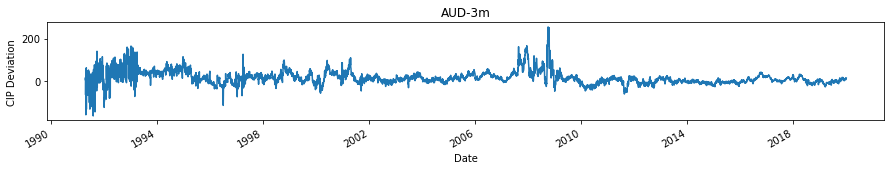

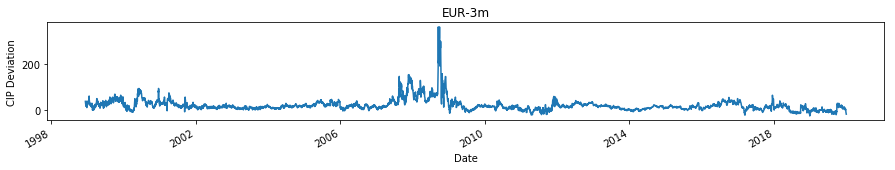

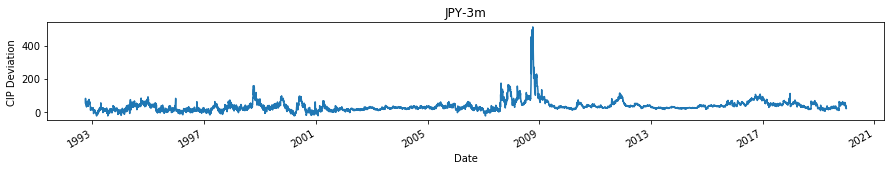

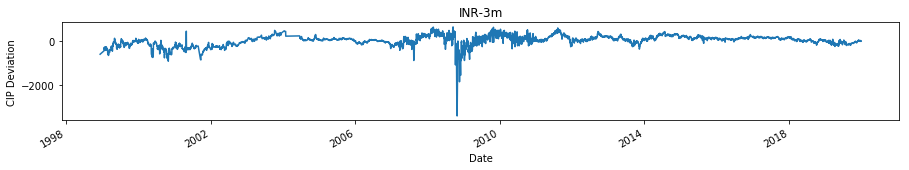

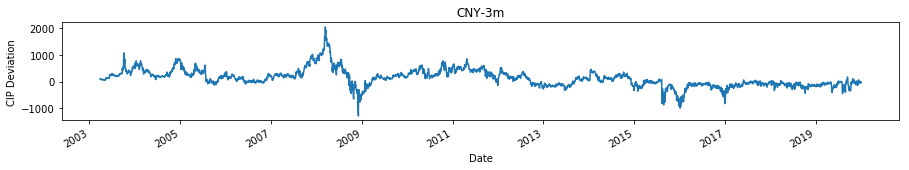

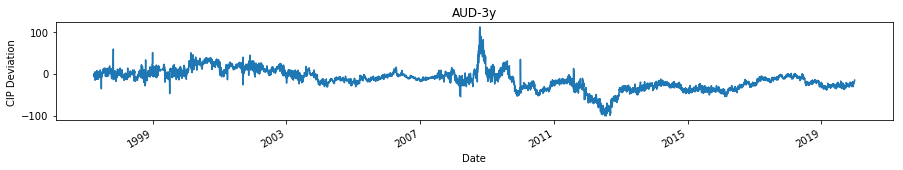

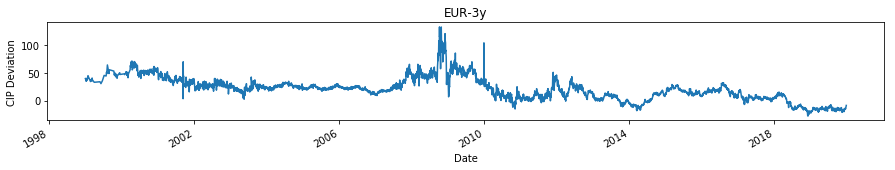

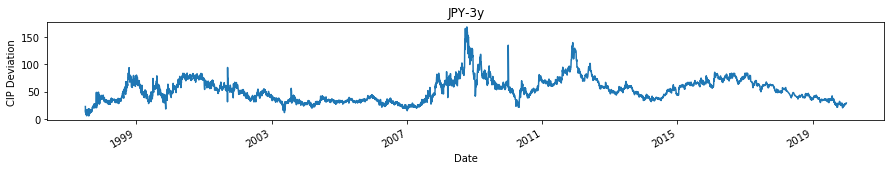

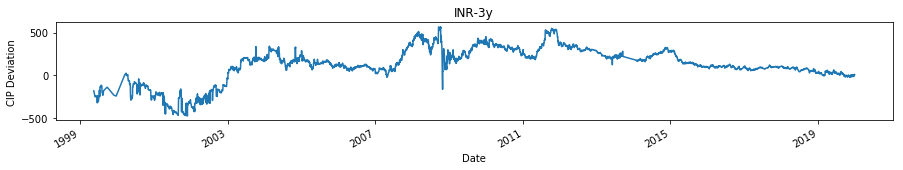

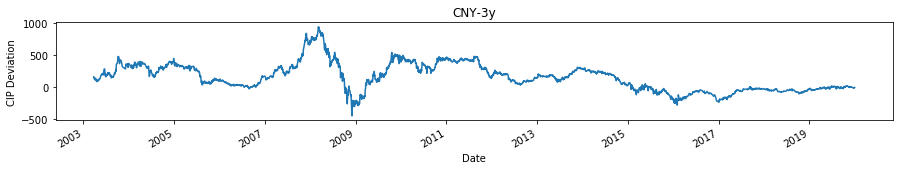

In [4]:
for tenor in tenors:
    dt = data[data['tenor'] == tenor]
    for currency in currencies:
        df = dt[dt['currency'] == currency]
        fig, ax = plt.subplots(figsize=(15, 2))
        df['cip_govt'].plot()
        ax.set(xlabel="Date",ylabel="CIP Deviation",title=currency + "-" + tenor)
        plt.show()

# Tenor-Currency Statistics

Statistics for all G10 countries

In [5]:
g10 = ['EUR', 'JPY', 'AUD']
data[data['currency'].isin(g10)][['currency', 'cip_govt', 'tenor']].groupby(['tenor', 'currency']).agg({'cip_govt':['mean', 'count', 'std', 'skew', 'max', 'min']})

cip_govt                                                   
                     mean count        std      skew         max         min
tenor currency                                                              
3m    AUD       15.674743  7276  30.616202  1.474882  255.187586 -162.839878
      EUR       22.161625  5483  26.654332  4.548563  360.439992  -23.617725
      JPY       33.661912  7059  34.065709  5.109373  512.367686  -25.004706
3y    AUD      -14.211430  5735  23.343303 -0.074224  111.750000 -100.880000
      EUR       20.326957  5046  20.347465  0.700601  133.170000  -27.405000
      JPY       52.457542  5475  21.538675  1.019208  168.507500    5.250000

In [6]:
eme = ['INR', 'CNY']
data[data['currency'].isin(eme)][['currency', 'cip_govt', 'tenor']].groupby(['tenor', 'currency']).agg({'cip_govt':['mean', 'count', 'std', 'skew', 'max', 'min']})

cip_govt                                           \
                      mean count         std      skew          max   
tenor currency                                                        
3m    CNY       133.382596  4238  322.812593  0.736216  2055.120212   
      INR        29.101993  4721  233.099153 -2.498594   641.999460   
3y    CNY       168.418663  3850  213.138590  0.538267   939.850000   
      INR       132.424436  4559  202.755394 -0.773515   568.110000   

                             
                        min  
tenor currency               
3m    CNY      -1282.157133  
      INR      -3395.728254  
3y    CNY       -446.485000  
      INR       -477.600000

1. We can see that the CIP deviations are very volatile in EME markets as compared to the G10 countries. This can be validated by looking at the min, max and standard deviations<br>

2. We have less data points available for EME markets which means that the EME market is less liquid as compared to the G10 countries<br>

3. For specific countries we observe that the skewness changes a lot when the tenor is changed (e.g EUR, JPY, INR) while for some countries there isnt much of a difference(e.g. CNY, AUD) 

# Stationarity Checks to evaluate predictive power of statistical models

In [7]:
for tenor in tenors:
    dt = data[data['tenor'] == tenor]
    for currency in currencies:
        df = dt[dt['currency'] == currency]
        adf = stat.adfuller(df['cip_govt'])
        df_stat = adf[0]
        p_val = adf[1]
        if p_val <= 0.05:
            print(currency + "-" + tenor + " is stationary at 5% with DF-stat: " + str(df_stat) + " and p-value: " + str(p_val))
        else:
            print(currency + "-" + tenor + " is NOT stationary at 5% with DF-stat: " + str(df_stat) + " and p-value: " + str(p_val))

AUD-3m is stationary at 5% with DF-stat: -6.550384808160184 and p-value: 8.881518933180364e-09
EUR-3m is stationary at 5% with DF-stat: -5.532569461373951 and p-value: 1.773926821017154e-06
JPY-3m is stationary at 5% with DF-stat: -6.139882483519682 and p-value: 8.018921705474681e-08
INR-3m is stationary at 5% with DF-stat: -5.065318336358837 and p-value: 1.645379028722202e-05
CNY-3m is stationary at 5% with DF-stat: -4.039789108359937 and p-value: 0.0012159120138656803
AUD-3y is stationary at 5% with DF-stat: -3.3111300915002473 and p-value: 0.01438823068765011
EUR-3y is stationary at 5% with DF-stat: -2.986261839848574 and p-value: 0.036197442248811426
JPY-3y is stationary at 5% with DF-stat: -3.9938489850100036 and p-value: 0.0014430644700040018
INR-3y is NOT stationary at 5% with DF-stat: -2.078764224494827 and p-value: 0.25313889399253403
CNY-3y is NOT stationary at 5% with DF-stat: -2.0983219911897484 and p-value: 0.24518987241351814


We see that all are stationary except INR-3y and CNY-3y

# Check if difference is stationary for INR-3y and CNY-3y

INR-3y

In [68]:
data.head()

,group,currency,tenor,rho,cip_govt,diff_y
date,,,,,,
1991-04-16,g10,AUD,3m,4.922851,7.714864,5.00
1991-04-17,g10,AUD,3m,4.879019,17.098071,5.05
1991-04-18,g10,AUD,3m,4.875202,1.479801,4.89
1991-04-19,g10,AUD,3m,5.485619,-63.561889,4.85
1991-04-22,g10,AUD,3m,4.566640,35.336041,4.92


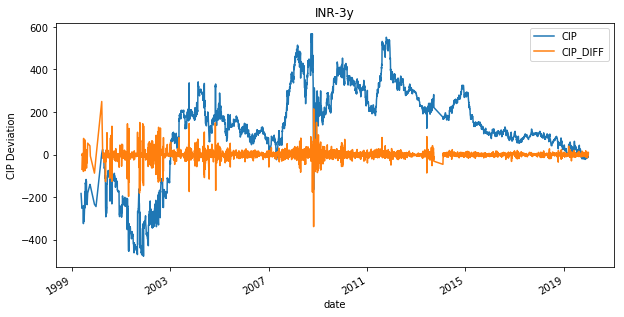

In [70]:
test = pd.DataFrame(data[(data['currency'] == 'INR') & (data['tenor'] == '3y')]['cip_govt'].values, columns=['CIP'], index=data[(data['currency'] == 'INR') & (data['tenor'] == '3y')].index)
test['CIP_DIFF'] = test['CIP'].diff()

fig, ax = plt.subplots(figsize=(10, 5))
ax.set(xlabel="Date",ylabel="CIP Deviation",title="INR-3y")
test.plot(legend=True, ax=ax)
plt.show()

In [9]:
adf = stat.adfuller(diff)
df_stat = adf[0]
p_val = adf[1]
if p_val <= 0.05:
    print("Difference of INR-3y is stationary at 5% with DF-stat: " + str(df_stat) + " and p-value: " + str(p_val))
else:
    print("Difference of INR-3y is NOT stationary at 5% with DF-stat: " + str(df_stat) + " and p-value: " + str(p_val))

Difference of INR-3y is stationary at 5% with DF-stat: -15.484423402472421 and p-value: 2.5316511678671845e-28


CNY-3y

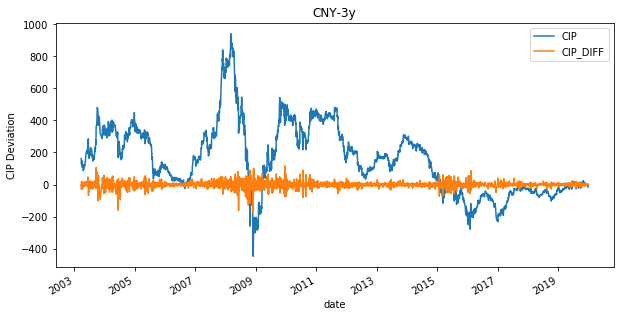

In [71]:
test = pd.DataFrame(data[(data['currency'] == 'CNY') & (data['tenor'] == '3y')]['cip_govt'].values, columns=['CIP'], index=data[(data['currency'] == 'CNY') & (data['tenor'] == '3y')].index)
test['CIP_DIFF'] = test['CIP'].diff()

fig, ax = plt.subplots(figsize=(10, 5))
ax.set(xlabel="Date",ylabel="CIP Deviation",title="CNY-3y")
test.plot(legend=True, ax=ax)
plt.show()

In [11]:
adf = stat.adfuller(diff)
df_stat = adf[0]
p_val = adf[1]
if p_val <= 0.05:
    print("Difference of CNY-3y is stationary at 5% with DF-stat: " + str(df_stat) + " and p-value: " + str(p_val))
else:
    print("Difference of CNY-3y is NOT stationary at 5% with DF-stat: " + str(df_stat) + " and p-value: " + str(p_val))

Difference of CNY-3y is stationary at 5% with DF-stat: -28.629702903566237 and p-value: 0.0


So we can work with the following series for fitting autoregressive models:
1. AUD-3m 
2. EUR-3m 
3. JPY-3m 
4. INR-3m 
5. CNY-3m 
6. AUD-3y 
7. EUR-3y 
8. JPY-3y 
9. First-order difference of INR-3y 
10. First-order difference of CNY-3y

# Autocorrelations

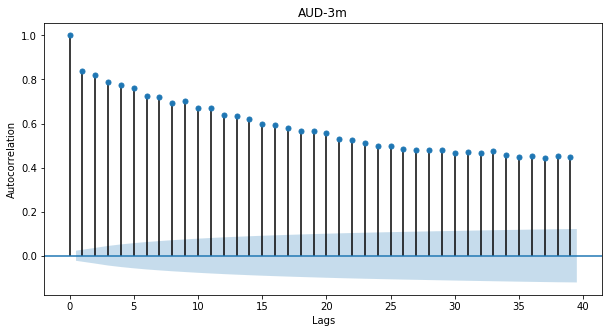

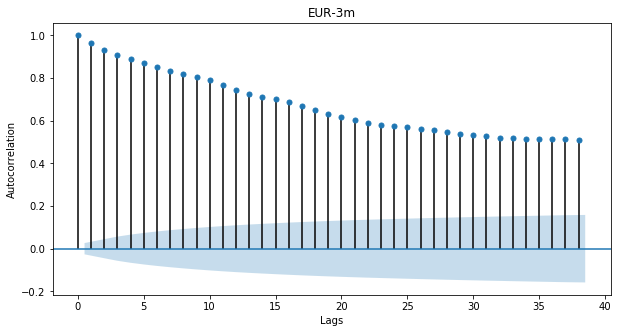

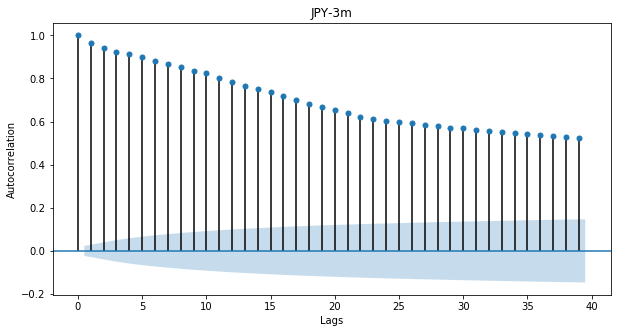

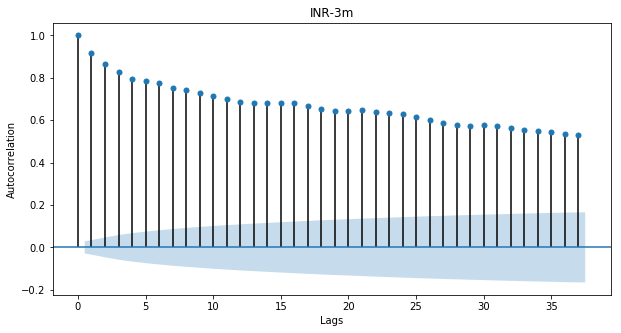

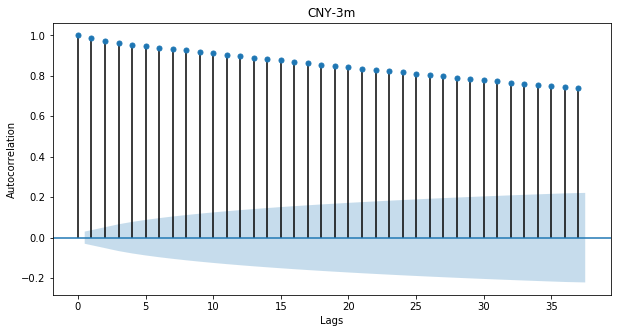

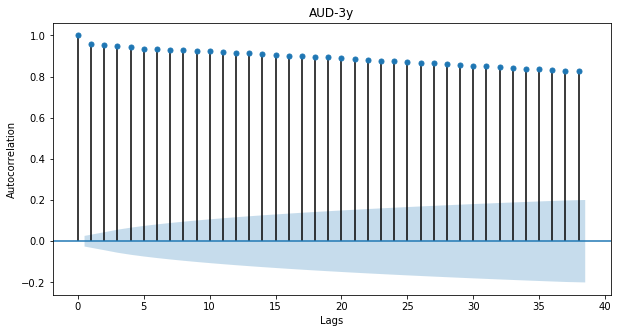

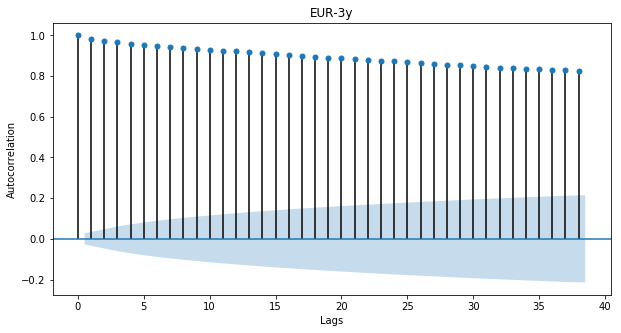

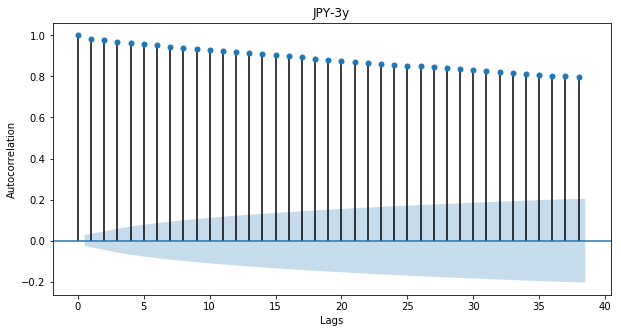

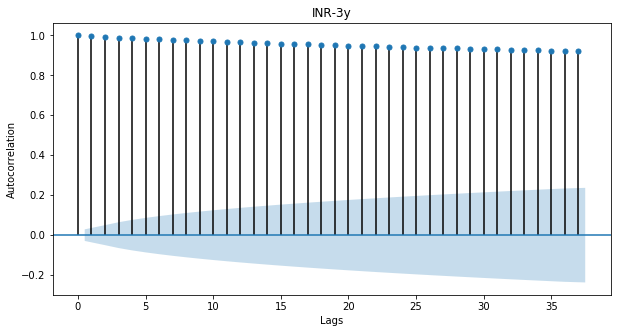

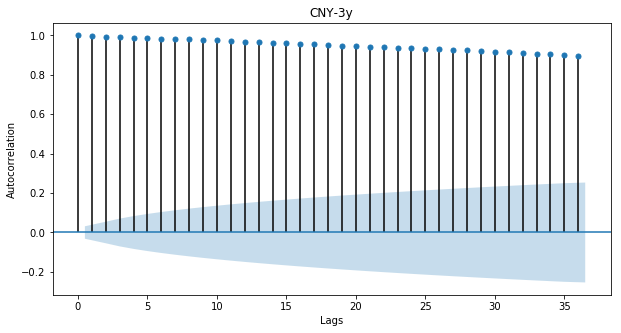

In [73]:
for tenor in tenors:
    dt = data[data['tenor'] == tenor]
    for currency in currencies:
        df = dt[dt['currency'] == currency]
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.set(xlabel="Lags",ylabel="Autocorrelation")
        sm.graphics.tsa.plot_acf(df['cip_govt'], ax=ax, title=currency + "-" + tenor)
        plt.savefig(currency + "-" + tenor + "_autocorrelation")
        plt.show()

# Auto-regressive models - AR (1)

Out of sample Performance

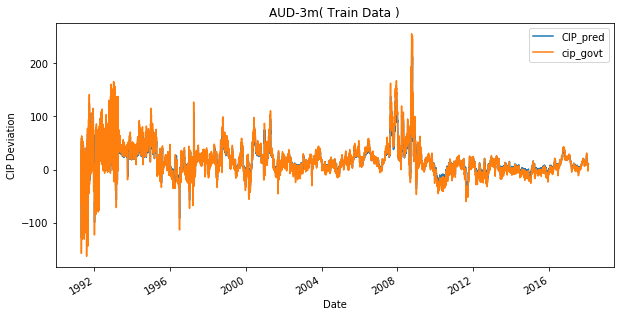

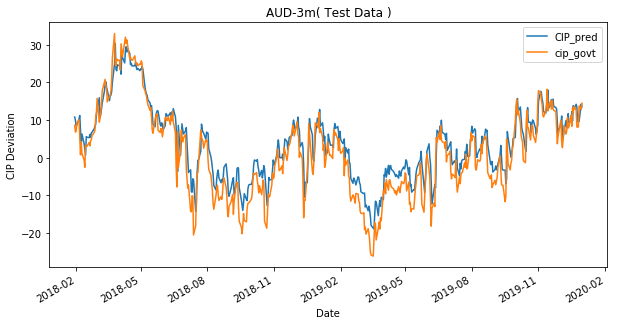

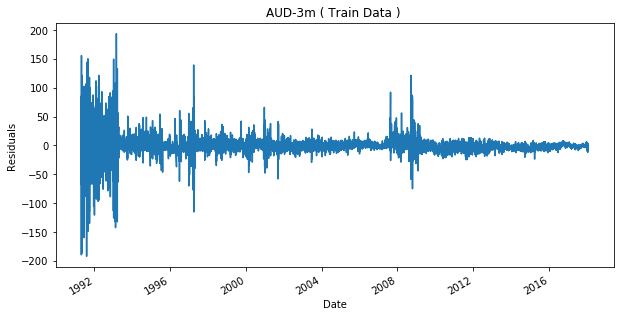

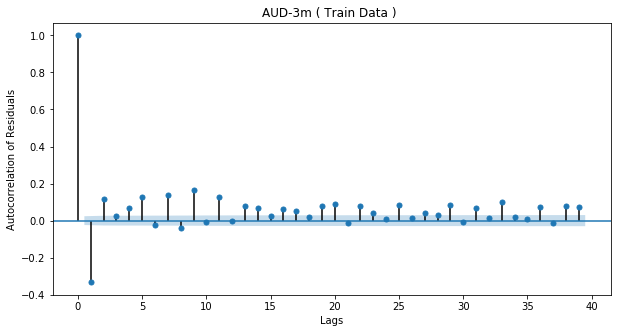

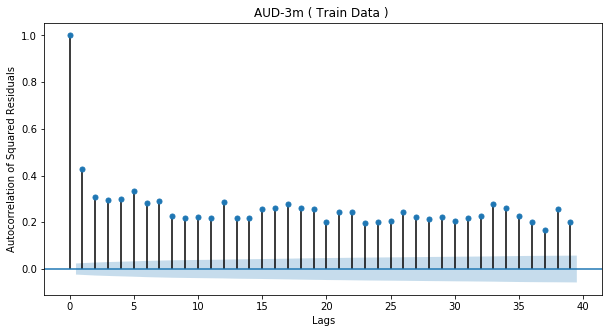

For currency: AUD and tenor: 3m RMSE: 4.415020937771449


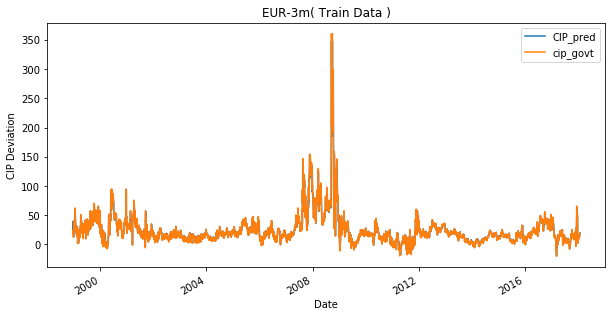

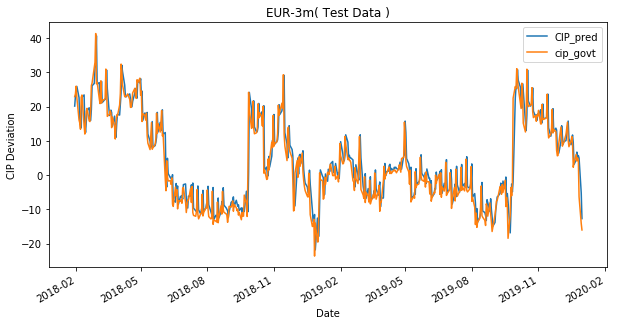

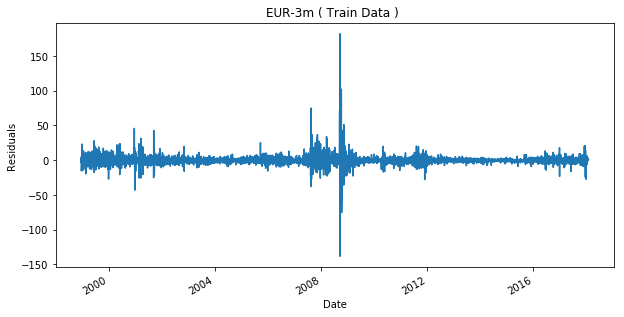

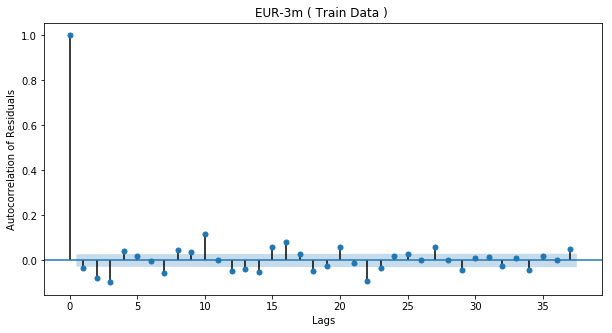

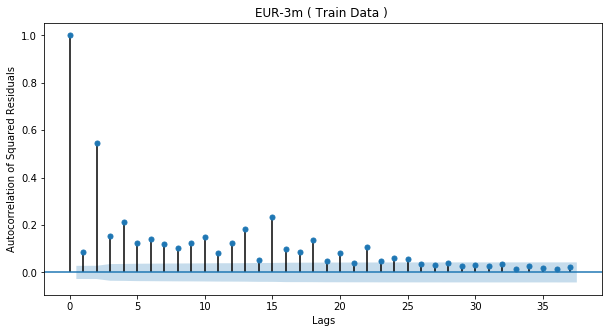

For currency: EUR and tenor: 3m RMSE: 4.760386745620907


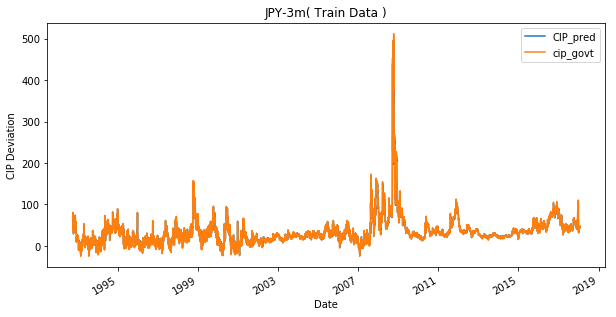

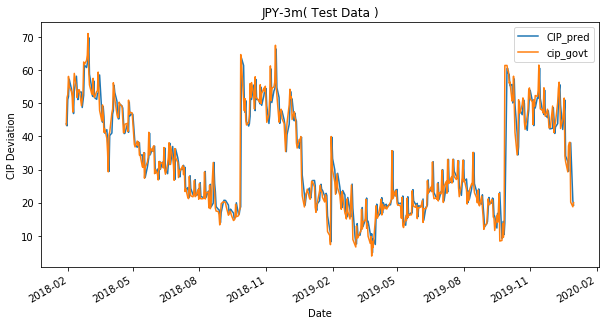

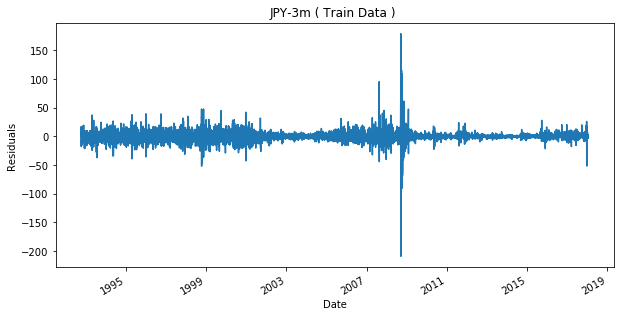

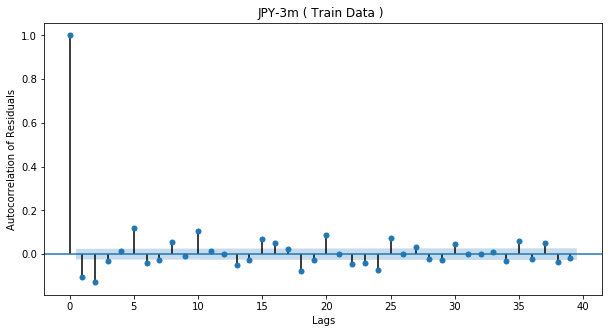

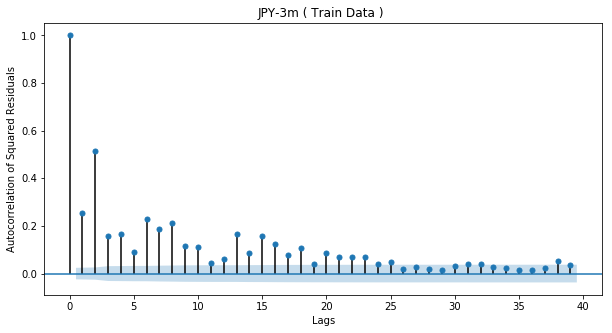

For currency: JPY and tenor: 3m RMSE: 5.53789600314632


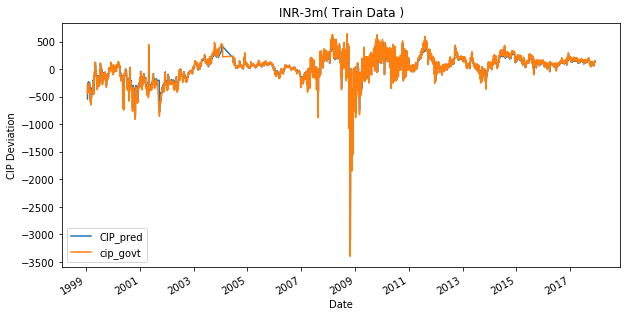

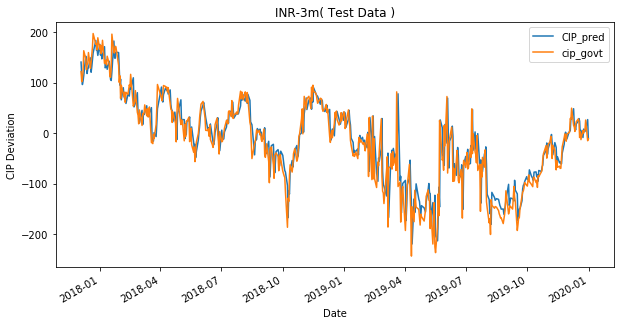

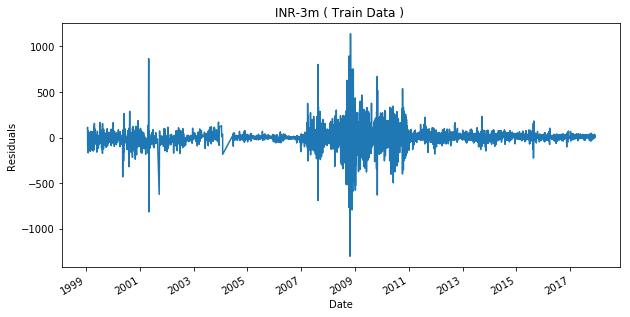

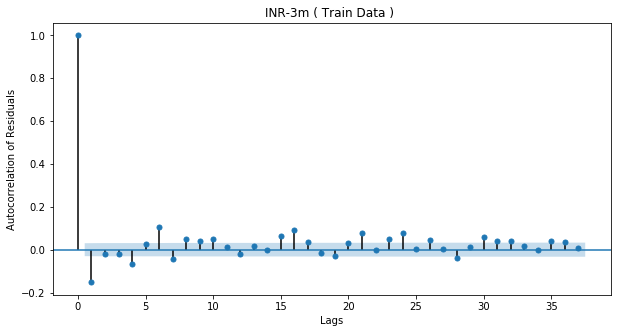

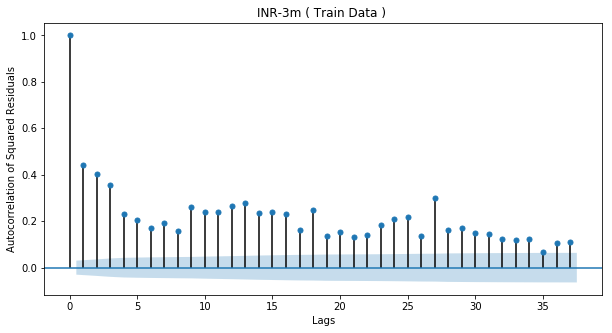

For currency: INR and tenor: 3m RMSE: 35.166618553389604


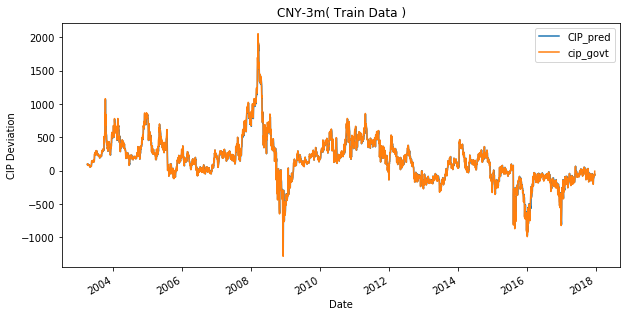

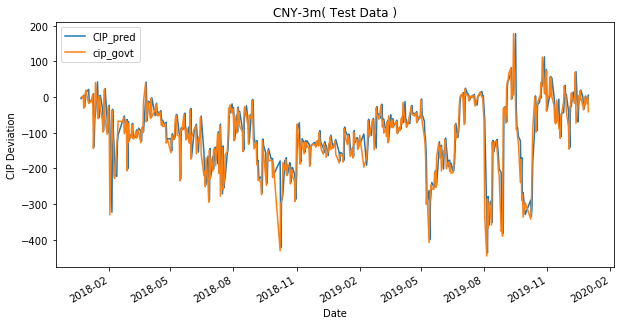

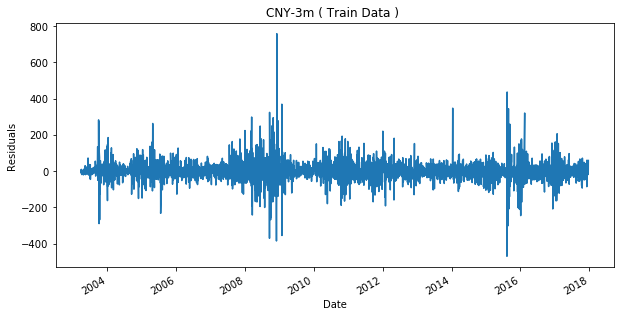

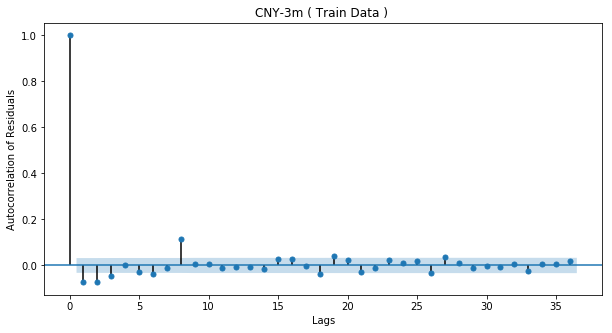

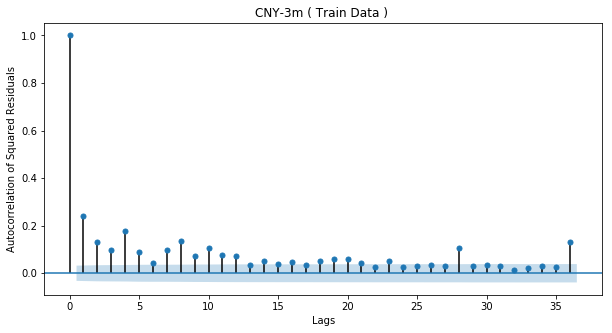

For currency: CNY and tenor: 3m RMSE: 58.665982255473345


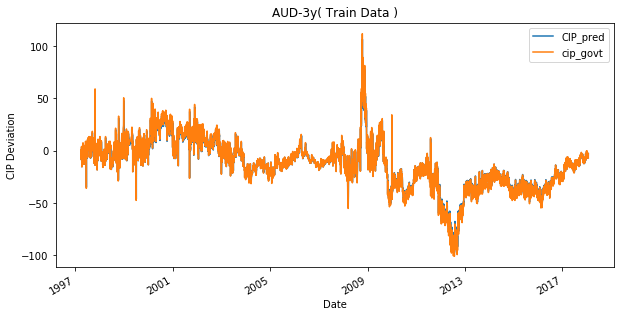

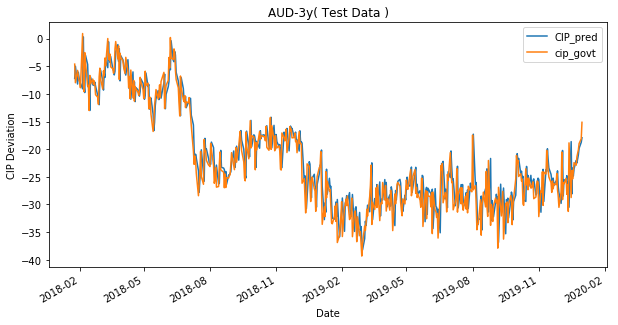

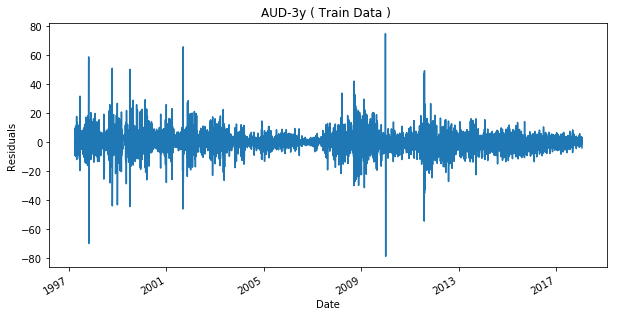

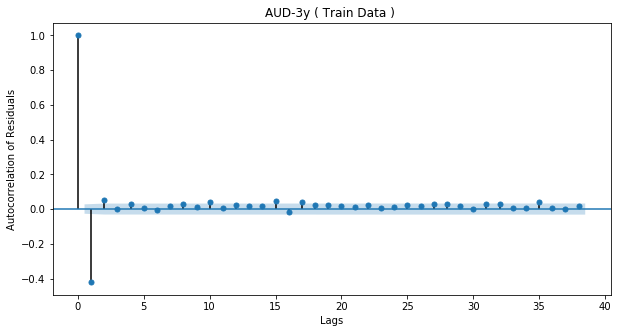

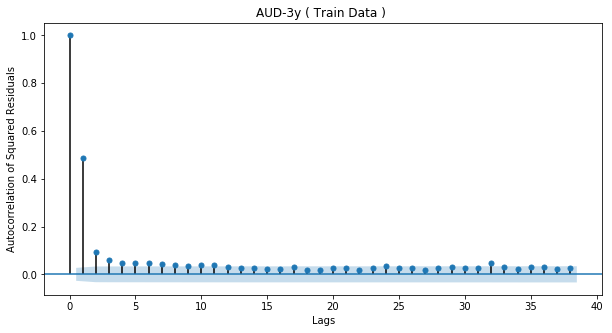

For currency: AUD and tenor: 3y RMSE: 3.3705919882736253


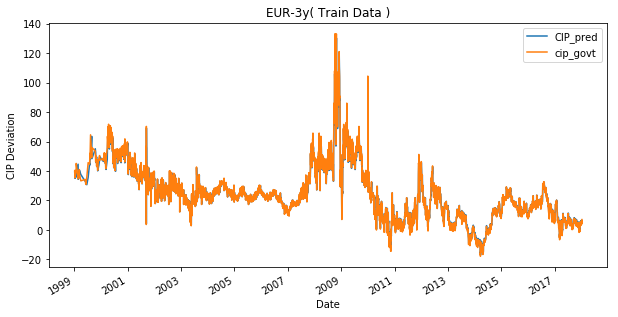

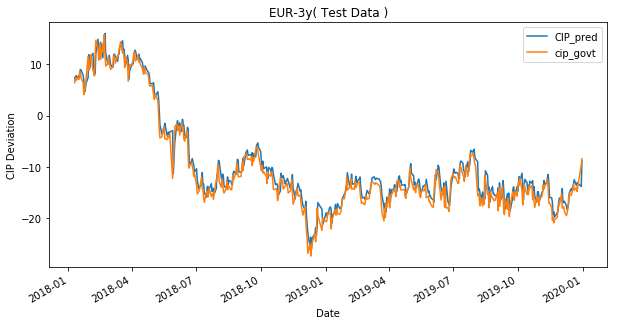

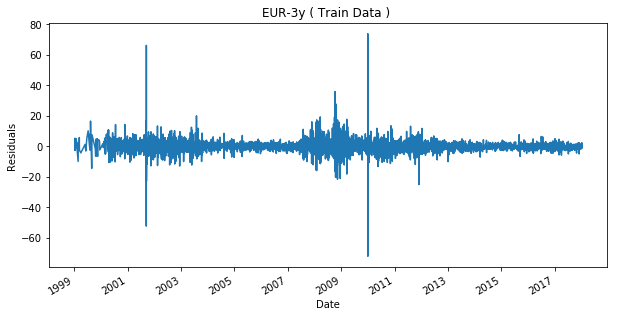

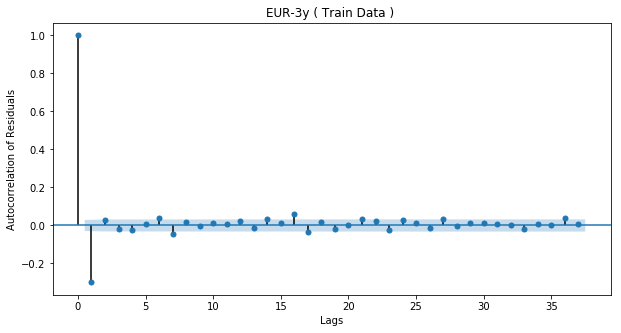

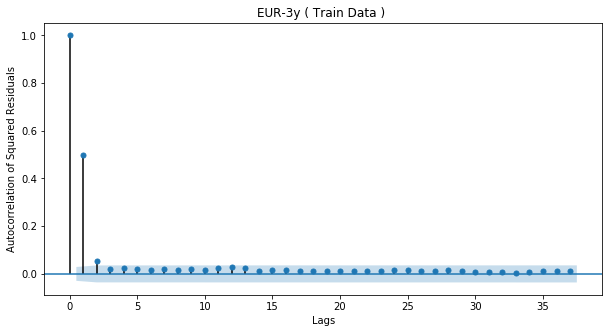

For currency: EUR and tenor: 3y RMSE: 1.8549461273897092


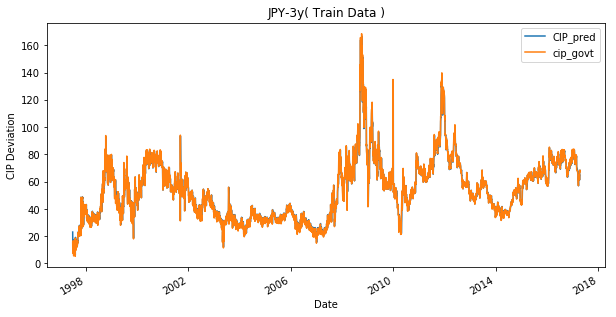

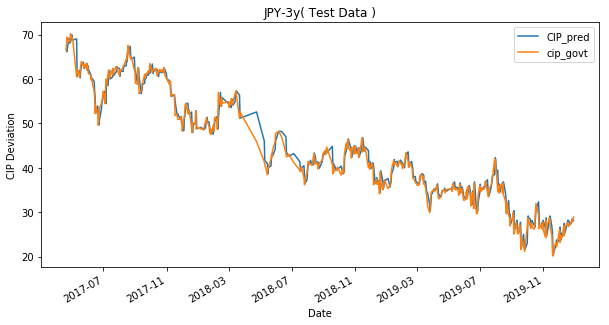

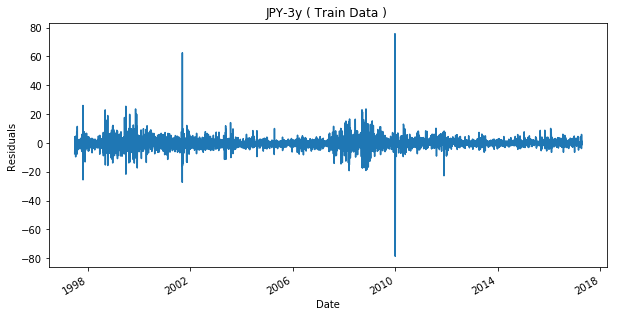

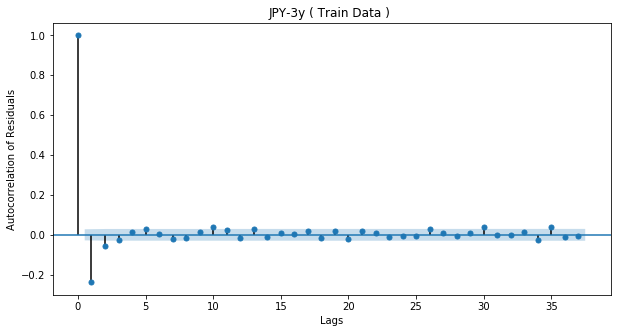

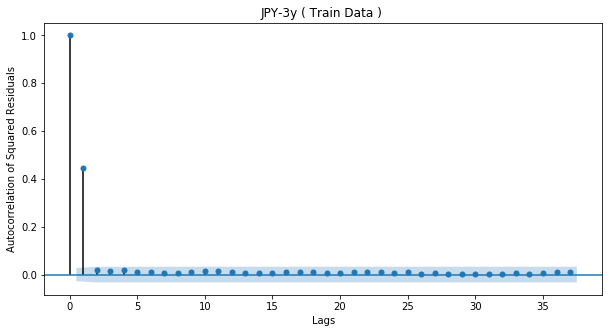

For currency: JPY and tenor: 3y RMSE: 1.6820258876820364


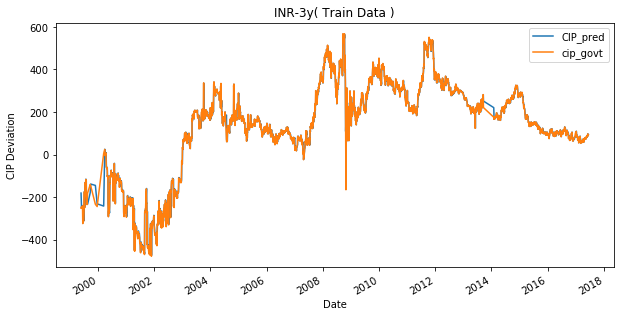

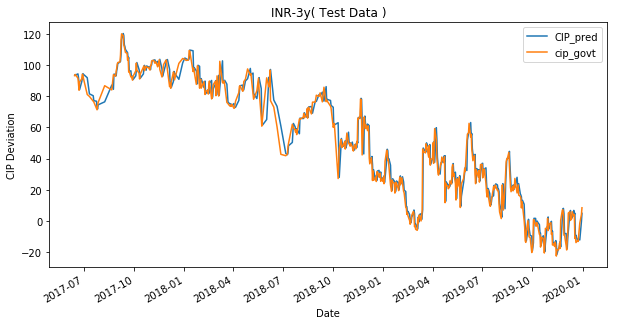

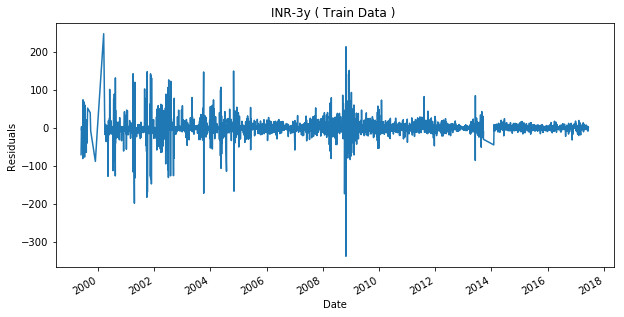

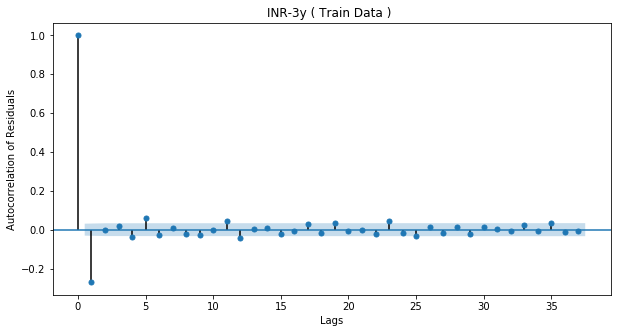

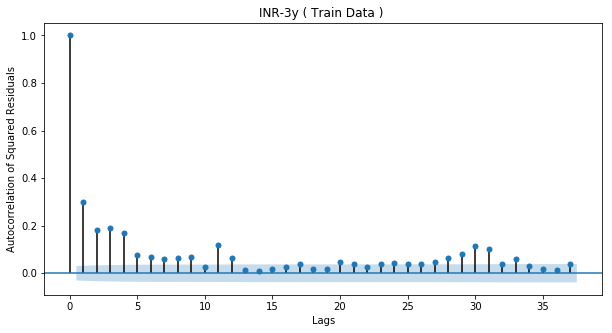

For currency: INR and tenor: 3y RMSE: 6.718523627556429


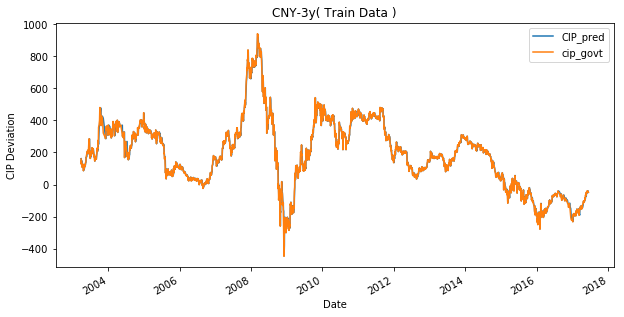

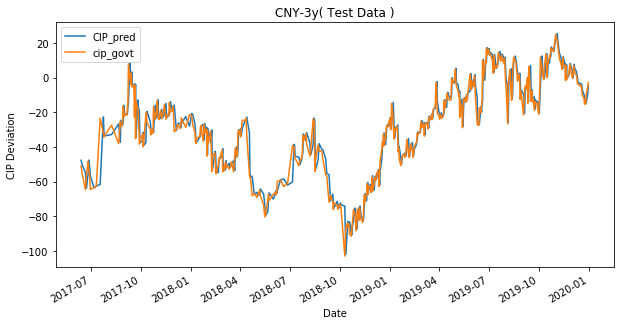

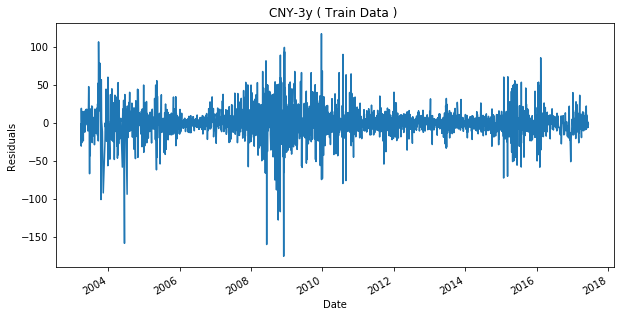

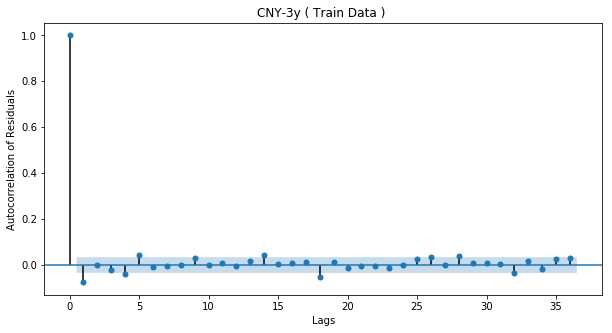

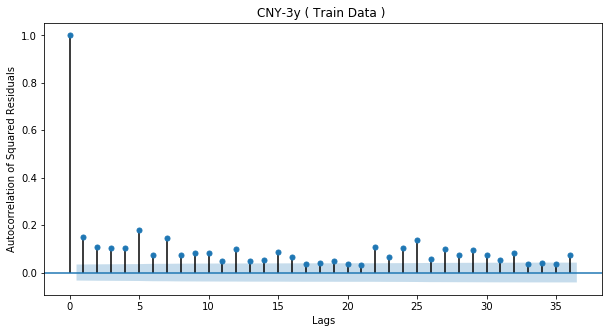

For currency: CNY and tenor: 3y RMSE: 6.947515386717834


In [74]:
for tenor in tenors:
    dt = data[data['tenor'] == tenor]
    for currency in currencies:
        df = dt[dt['currency'] == currency]
        df['cip_govt_1'] = df['cip_govt'].shift(1)
        df.dropna(inplace=True)
        
        train = df[:len(df)-500]
        test = df[len(df)-500:]
        X = train['cip_govt_1']
        Y = train['cip_govt']
        X = sm.add_constant(X)
        
        model = sm.OLS(Y,X)
        results = model.fit()
        train['CIP_pred'] = np.dot(X, results.params)
        train['resid'] = results.resid.values
        X = test['cip_govt_1']
        X = sm.add_constant(X)
        test['CIP_pred'] = np.dot(X, results.params)
        test['resid'] = test['CIP_pred'] - test['cip_govt']
        
        fig, ax = plt.subplots(figsize=(10, 5))
        train['CIP_pred'].plot(legend=True)
        train['cip_govt'].plot(legend=True)
        ax.set(xlabel="Date",ylabel="CIP Deviation",title=currency + "-" + tenor + "( Train Data )")
        plt.show()
        
        fig, ax = plt.subplots(figsize=(10, 5))
        test['CIP_pred'].plot(legend=True)
        test['cip_govt'].plot(legend=True)
        ax.set(xlabel="Date",ylabel="CIP Deviation",title=currency + "-" + tenor + "( Test Data )")
        plt.show()
        
        fig, ax = plt.subplots(figsize=(10, 5))
        train['resid'].plot()
        ax.set(xlabel="Date",ylabel="Residuals",title=currency + "-" + tenor + " ( Train Data ) ")
        plt.show()
        
         
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.set(xlabel="Lags",ylabel="Autocorrelation of Residuals")
        sm.graphics.tsa.plot_acf(train['resid'], ax=ax, title=currency + "-" + tenor + " ( Train Data ) ")
        plt.show()
        
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.set(xlabel="Lags",ylabel="Autocorrelation of Squared Residuals")
        sm.graphics.tsa.plot_acf(train['resid']**2, ax=ax, title=currency + "-" + tenor + " ( Train Data ) ")
        plt.show()
        
        print("For currency: " + currency + " and tenor: " + tenor + " RMSE: " + str(np.sqrt(np.mean(test['resid']**2))))

# GARCH model

# Vector Auto-regression between G10

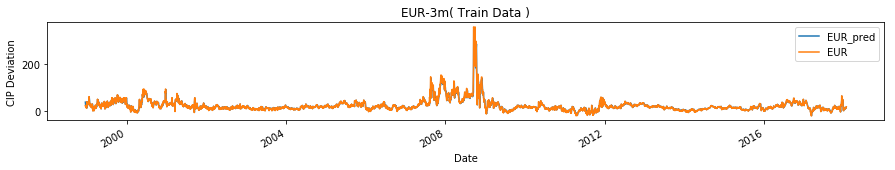

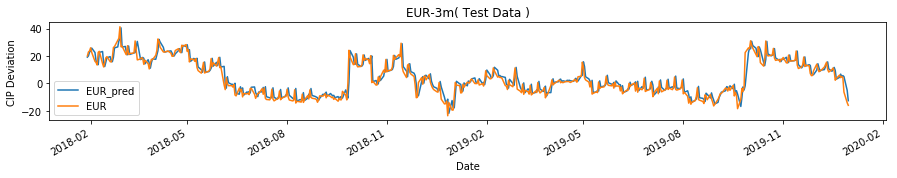

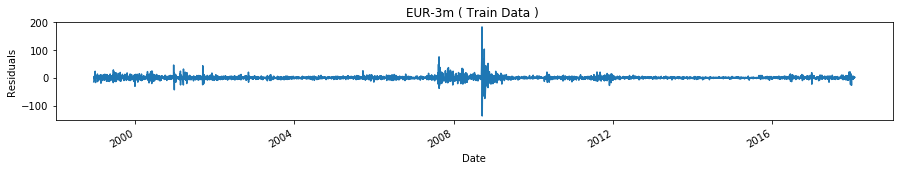

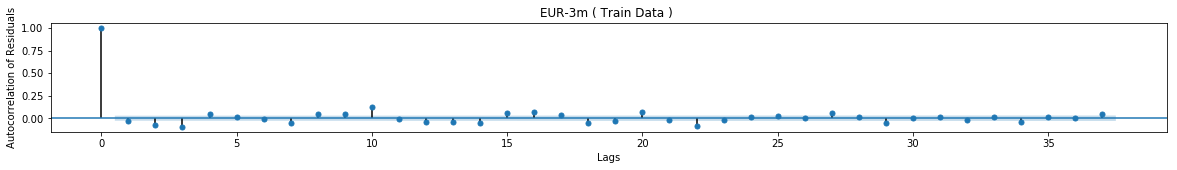

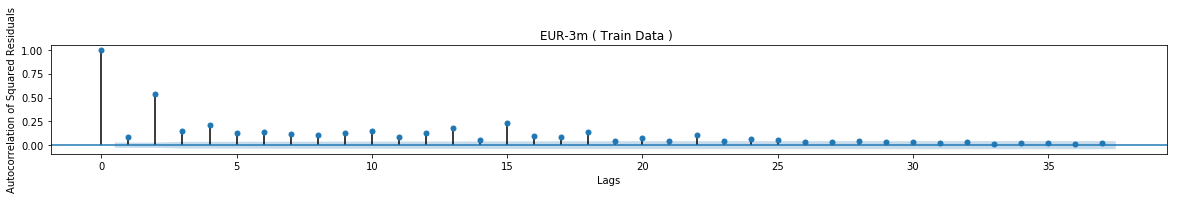

For currency: EUR and tenor: 3m RMSE: 4.765797685026195


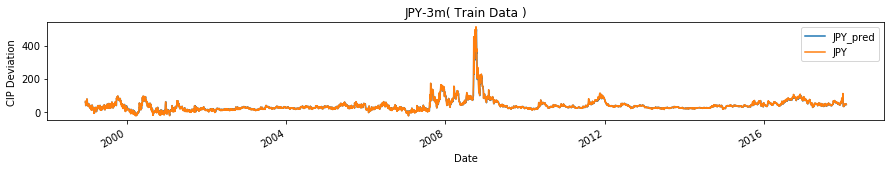

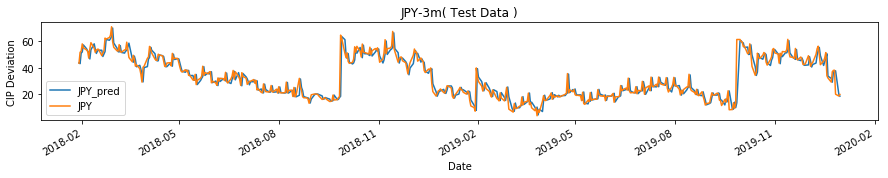

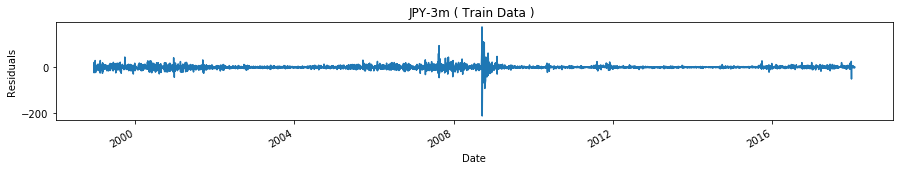

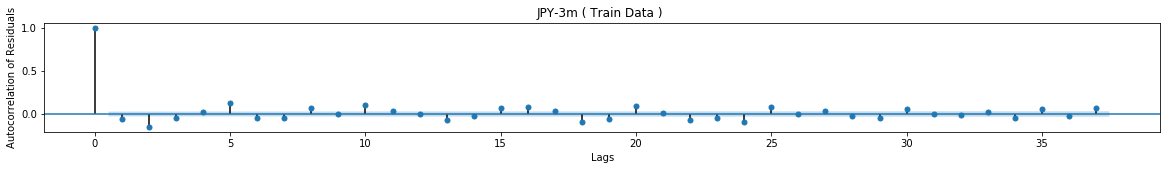

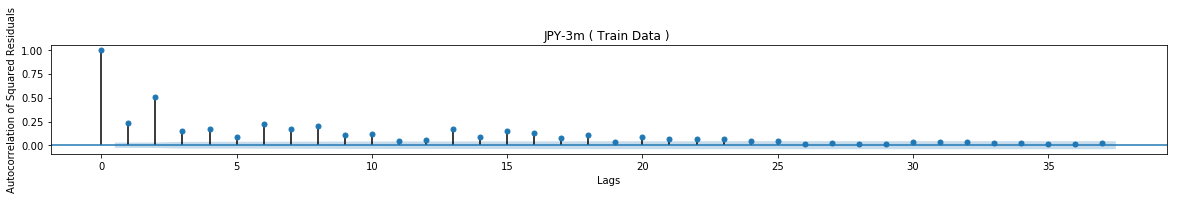

For currency: JPY and tenor: 3m RMSE: 5.546412513241613


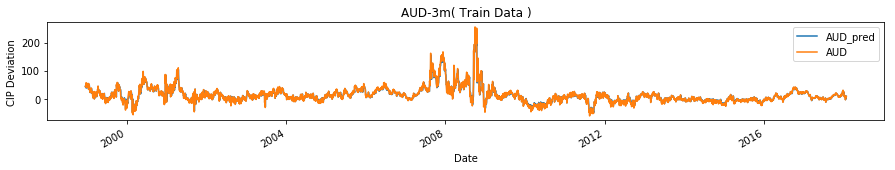

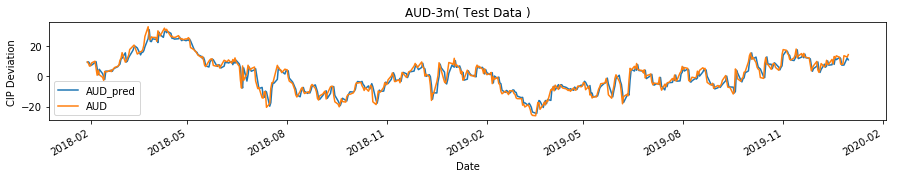

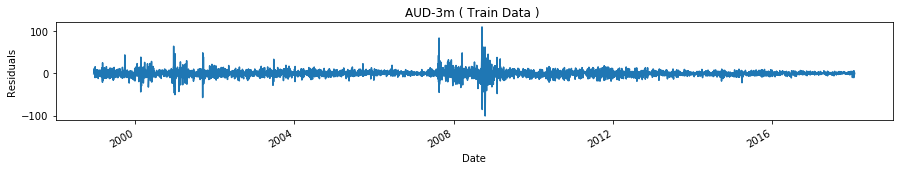

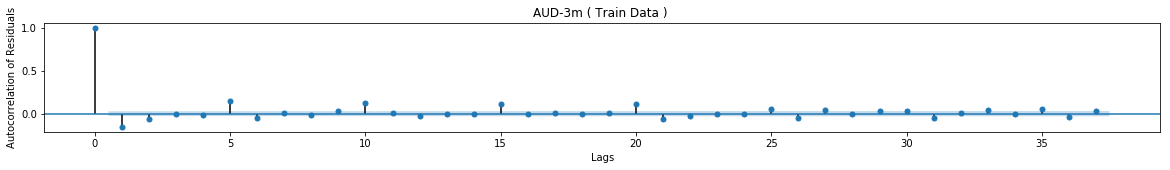

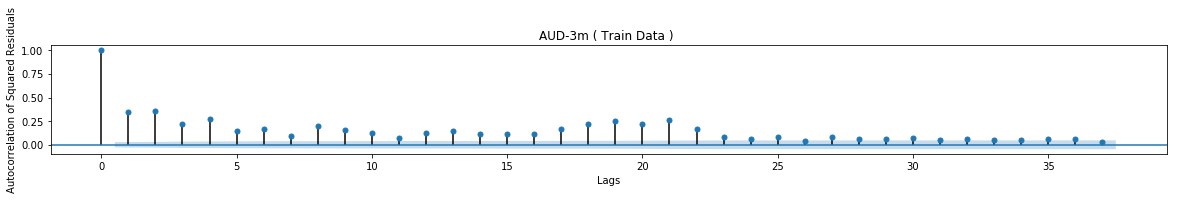

For currency: AUD and tenor: 3m RMSE: 3.2461696829434254


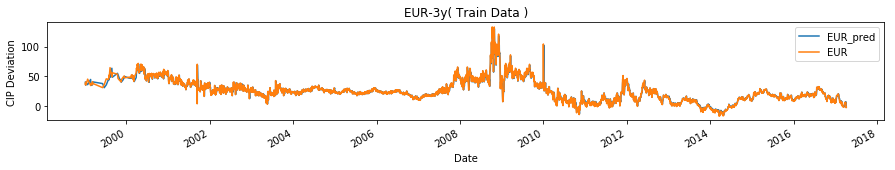

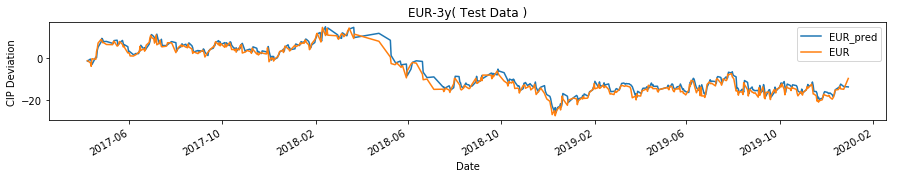

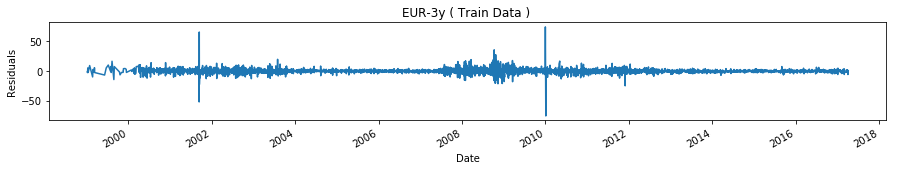

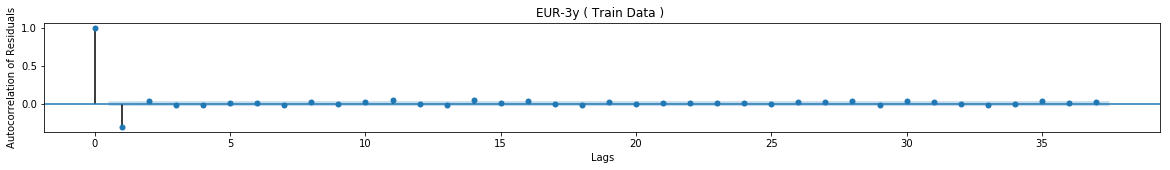

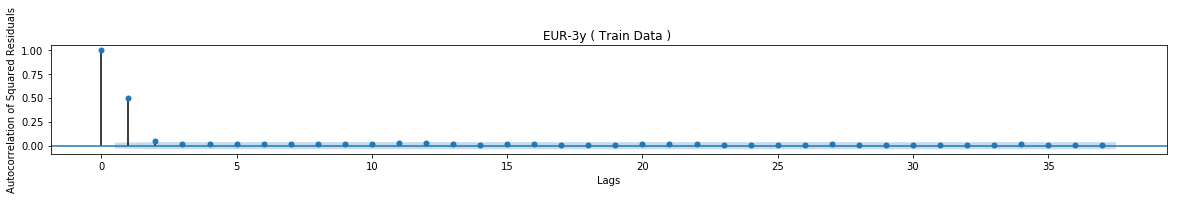

For currency: EUR and tenor: 3y RMSE: 1.9389055888581814


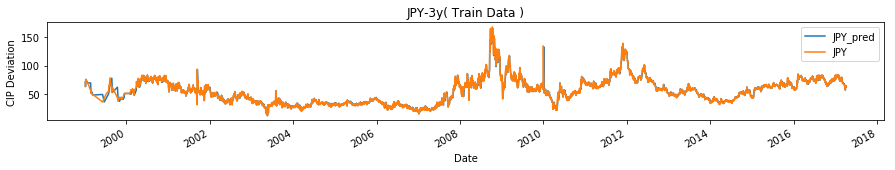

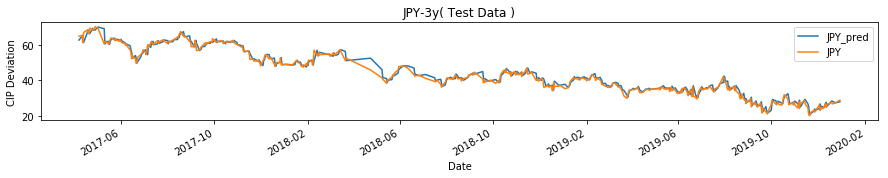

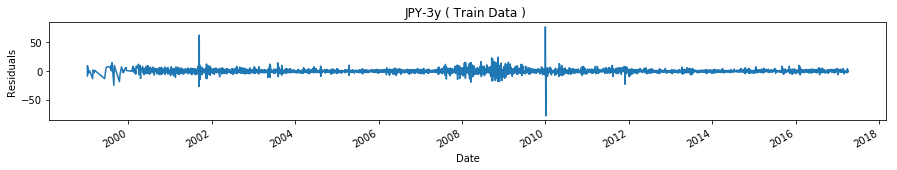

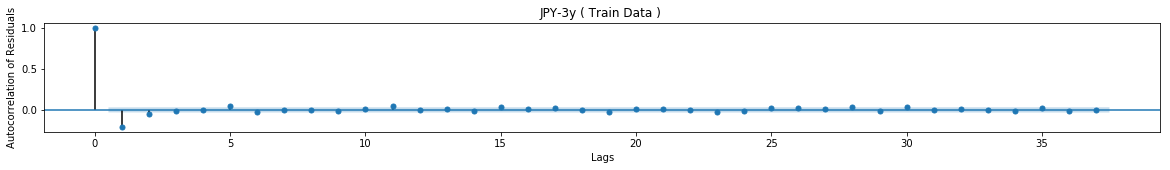

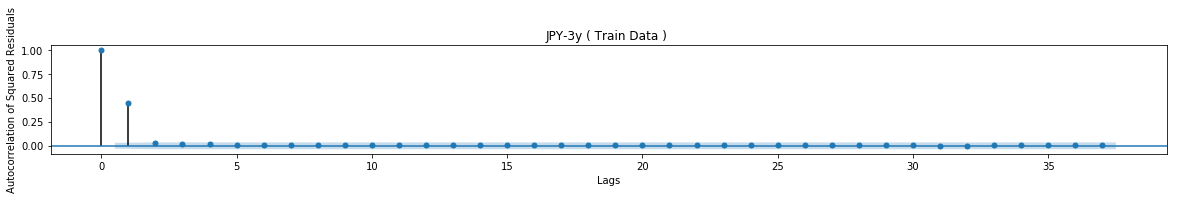

For currency: JPY and tenor: 3y RMSE: 1.745791224877027


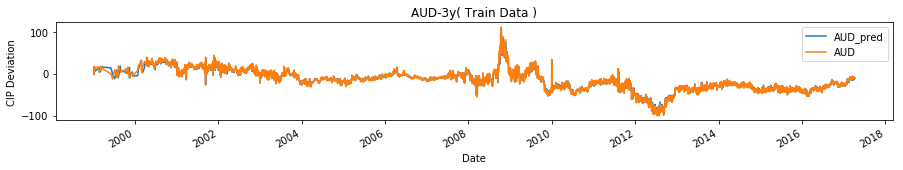

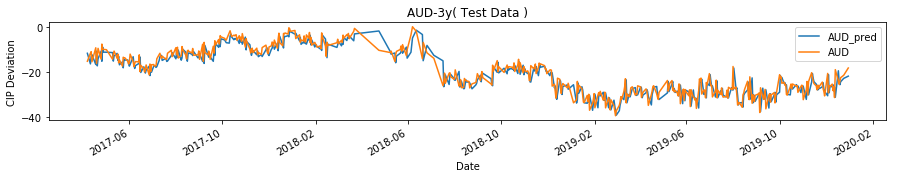

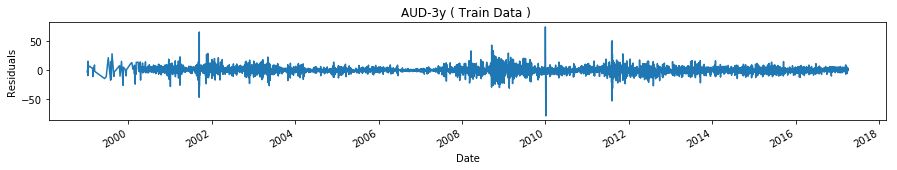

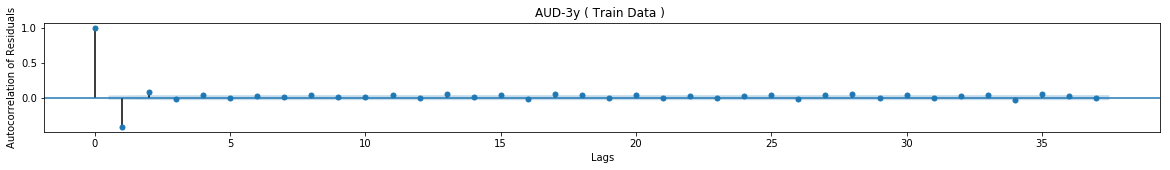

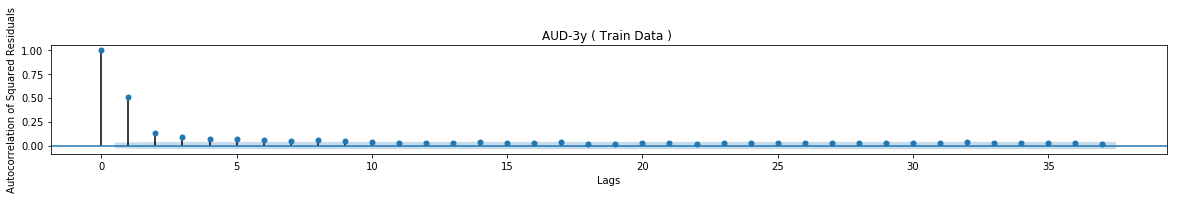

For currency: AUD and tenor: 3y RMSE: 3.544937920064891


In [14]:
for tenor in tenors:
    df = data[data['tenor'] == tenor]
    df = df[df['currency'].isin(g10)][['currency', 'cip_govt']]
        
    g10_data = pd.DataFrame()
    AUD = pd.DataFrame(df[df['currency'] == 'AUD']['cip_govt'].values, columns=['AUD'], index=df[df['currency'] == 'AUD']['cip_govt'].index)
    EUR = pd.DataFrame(df[df['currency'] == 'EUR']['cip_govt'].values, columns=['EUR'], index=df[df['currency'] == 'EUR']['cip_govt'].index)
    JPY = pd.DataFrame(df[df['currency'] == 'JPY']['cip_govt'].values, columns=['JPY'], index=df[df['currency'] == 'JPY']['cip_govt'].index)
    g10_data = AUD.merge(EUR, left_index=True, right_index=True)
    g10_data = JPY.merge(g10_data, left_index=True, right_index=True)
    g10_data['AUD_1'] = g10_data['AUD'].shift(1)
    g10_data['EUR_1'] = g10_data['EUR'].shift(1)
    g10_data['JPY_1'] = g10_data['JPY'].shift(1)
    
    g10_data.dropna(inplace=True)
    
    train = g10_data[:len(g10_data)-500]
    test = g10_data[len(g10_data)-500:]
    
    for currency in g10:
        X = train[['AUD_1', 'EUR_1', 'JPY_1']]
        Y = train[currency] 
        X = sm.add_constant(X)
        
        model = sm.OLS(Y,X)
        results = model.fit()

        train[currency+"_pred"] = np.dot(X, results.params)
        train['resid'] = results.resid.values
        X = test[['AUD_1', 'EUR_1', 'JPY_1']]
        X = sm.add_constant(X)
        test[currency+"_pred"] = np.dot(X, results.params)
        test['resid'] = test[currency+"_pred"] - test[currency]
        
        fig, ax = plt.subplots(figsize=(15, 2))
        train[currency+"_pred"].plot(legend=True)
        train[currency].plot(legend=True)
        ax.set(xlabel="Date",ylabel="CIP Deviation",title=currency + "-" + tenor + "( Train Data )")
        plt.show()
        
        fig, ax = plt.subplots(figsize=(15, 2))
        test[currency+"_pred"].plot(legend=True)
        test[currency].plot(legend=True)
        ax.set(xlabel="Date",ylabel="CIP Deviation",title=currency + "-" + tenor + "( Test Data )")
        plt.show()
        
        fig, ax = plt.subplots(figsize=(15, 2))
        train['resid'].plot()
        ax.set(xlabel="Date",ylabel="Residuals",title=currency + "-" + tenor + " ( Train Data ) ")
        plt.show()
        
         
        fig, ax = plt.subplots(figsize=(20, 2))
        ax.set(xlabel="Lags",ylabel="Autocorrelation of Residuals")
        sm.graphics.tsa.plot_acf(train['resid'], ax=ax, title=currency + "-" + tenor + " ( Train Data ) ")
        plt.show()
        
        fig, ax = plt.subplots(figsize=(20, 2))
        ax.set(xlabel="Lags",ylabel="Autocorrelation of Squared Residuals")
        sm.graphics.tsa.plot_acf(train['resid']**2, ax=ax, title=currency + "-" + tenor + " ( Train Data ) ")
        plt.show()
        
        print("For currency: " + currency + " and tenor: " + tenor + " RMSE: " + str(np.sqrt(np.mean(test['resid']**2))))

# Vector Auto-regression between EME

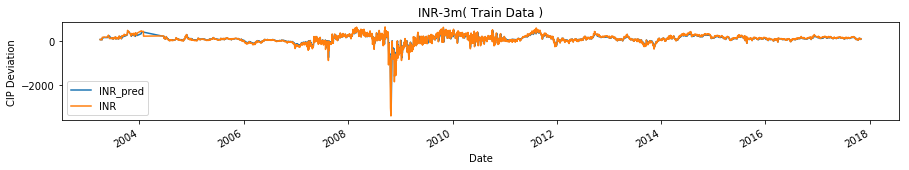

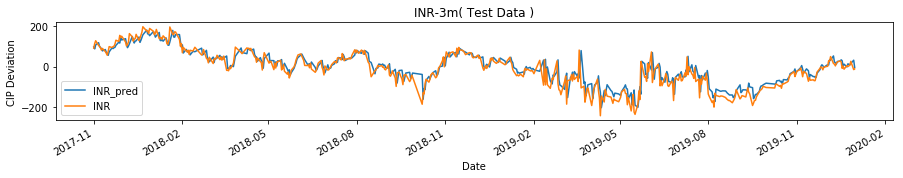

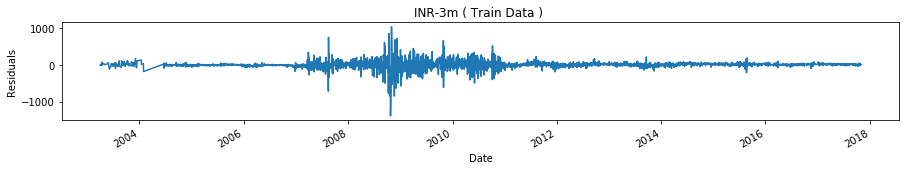

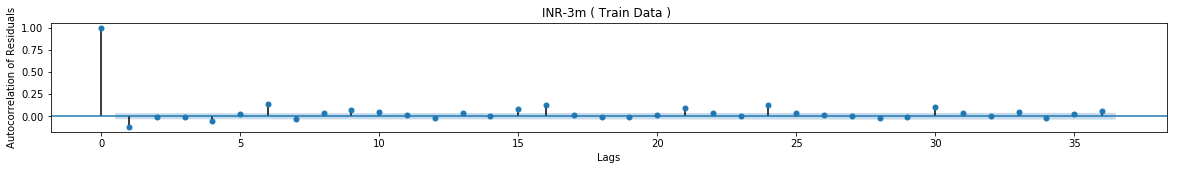

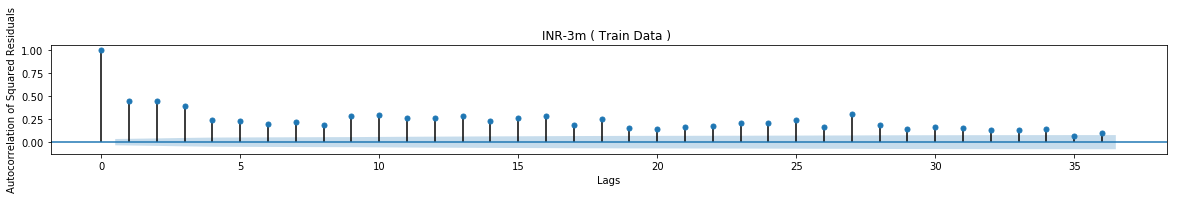

For currency: INR and tenor: 3m RMSE: 36.40007884401784


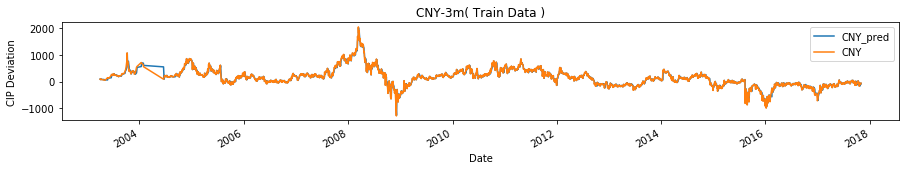

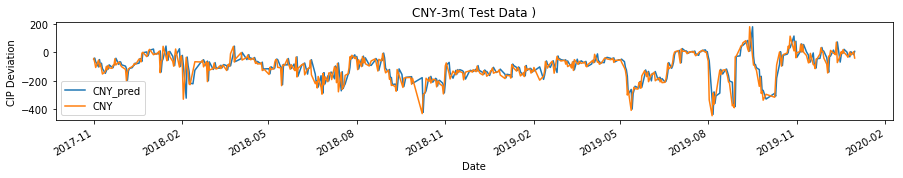

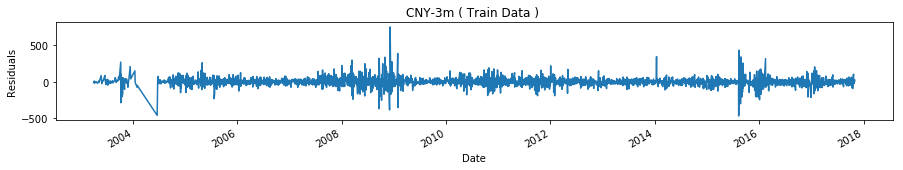

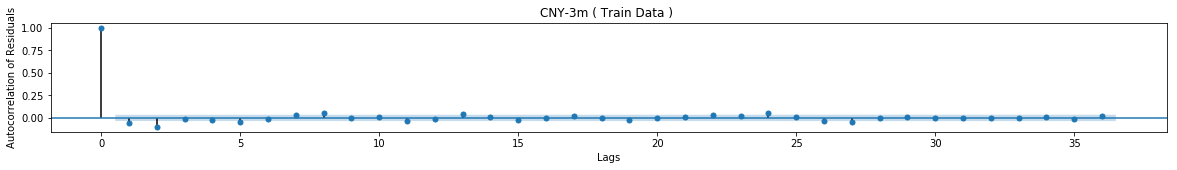

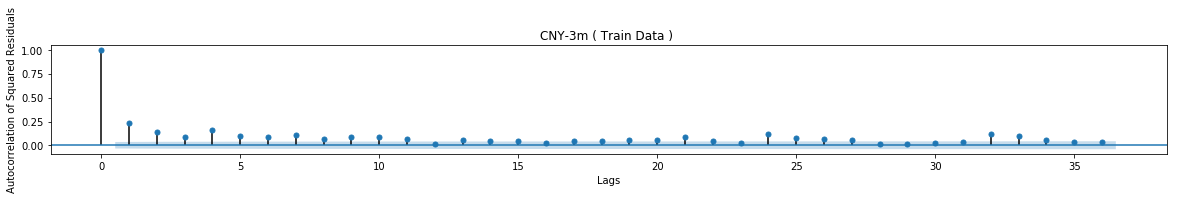

For currency: CNY and tenor: 3m RMSE: 58.215553652545736


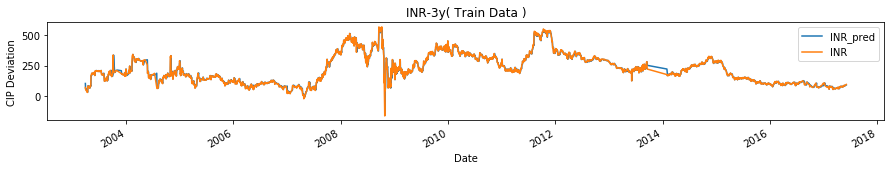

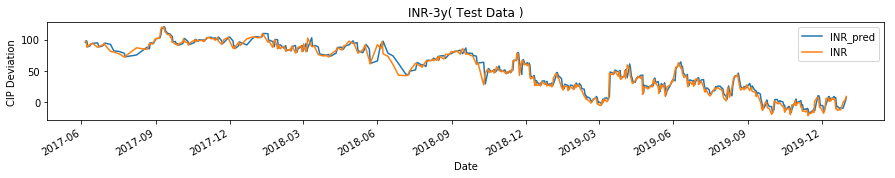

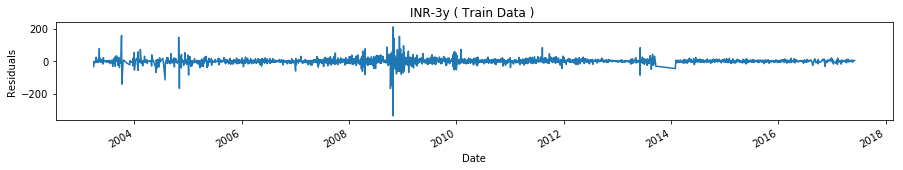

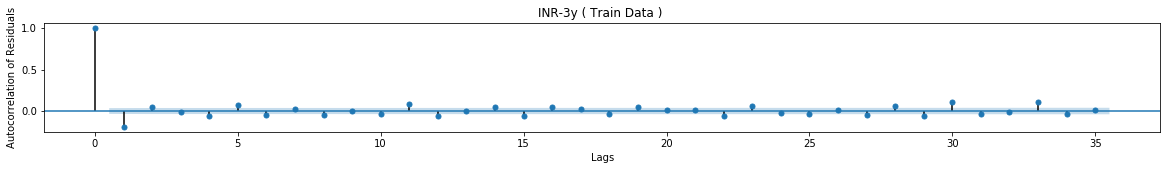

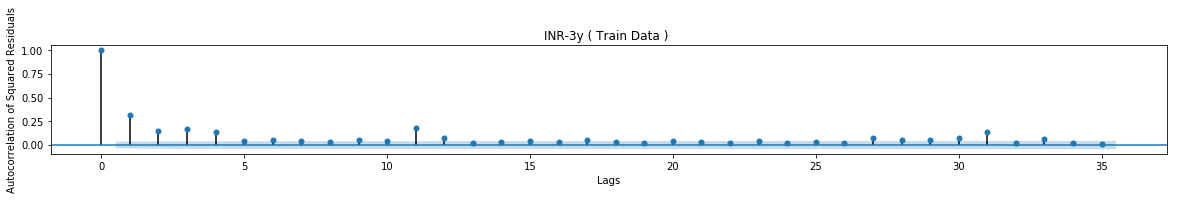

For currency: INR and tenor: 3y RMSE: 6.933557868052758


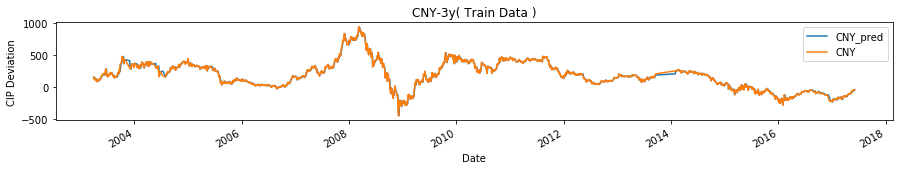

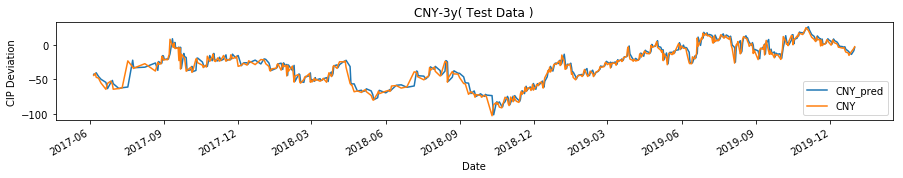

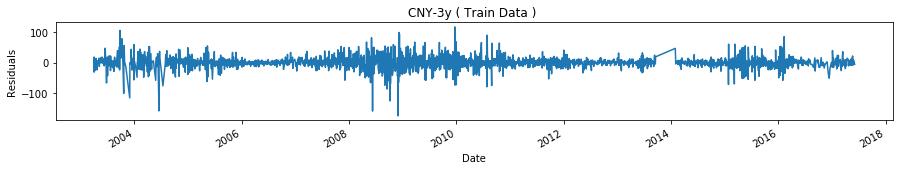

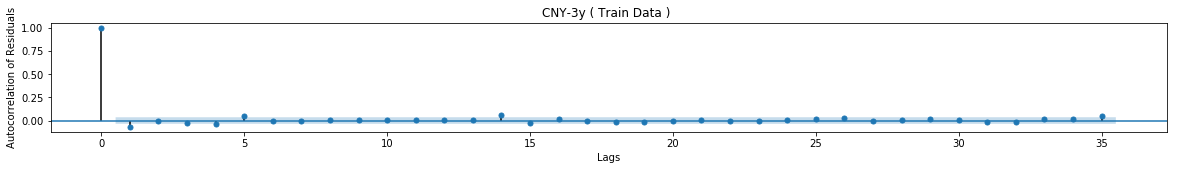

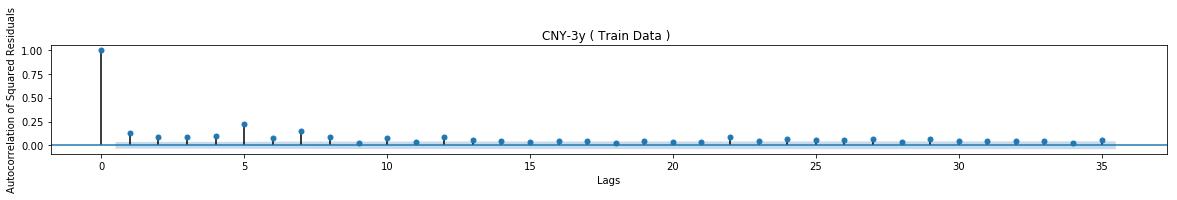

For currency: CNY and tenor: 3y RMSE: 6.990627145155472


In [30]:
for tenor in tenors:
    df = data[data['tenor'] == tenor]
    df = df[df['currency'].isin(eme)][['currency', 'cip_govt']]
        
    eme_data = pd.DataFrame()
    CNY = pd.DataFrame(df[df['currency'] == 'CNY']['cip_govt'].values, columns=['CNY'], index=df[df['currency'] == 'CNY']['cip_govt'].index)
    INR = pd.DataFrame(df[df['currency'] == 'INR']['cip_govt'].values, columns=['INR'], index=df[df['currency'] == 'INR']['cip_govt'].index)
    eme_data = CNY.merge(INR, left_index=True, right_index=True)
    eme_data['CNY_1'] = eme_data['CNY'].shift(1)
    eme_data['INR_1'] = eme_data['INR'].shift(1)
    
    eme_data.dropna(inplace=True)
    
    train = eme_data[:len(eme_data)-500]
    test = eme_data[len(eme_data)-500:]
    
    for currency in eme:
        X = train[['CNY_1', 'INR_1']]
        Y = train[currency] 
        X = sm.add_constant(X)
        
        model = sm.OLS(Y,X)
        results = model.fit()

        train[currency+"_pred"] = np.dot(X, results.params)
        train['resid'] = results.resid.values
        X = test[['CNY_1', 'INR_1']]
        X = sm.add_constant(X)
        test[currency+"_pred"] = np.dot(X, results.params)
        test['resid'] = test[currency+"_pred"] - test[currency]
        
        fig, ax = plt.subplots(figsize=(15, 2))
        train[currency+"_pred"].plot(legend=True)
        train[currency].plot(legend=True)
        ax.set(xlabel="Date",ylabel="CIP Deviation",title=currency + "-" + tenor + "( Train Data )")
        plt.show()
        
        fig, ax = plt.subplots(figsize=(15, 2))
        test[currency+"_pred"].plot(legend=True)
        test[currency].plot(legend=True)
        ax.set(xlabel="Date",ylabel="CIP Deviation",title=currency + "-" + tenor + "( Test Data )")
        plt.show()
        
        fig, ax = plt.subplots(figsize=(15, 2))
        train['resid'].plot()
        ax.set(xlabel="Date",ylabel="Residuals",title=currency + "-" + tenor + " ( Train Data ) ")
        plt.show()
        
         
        fig, ax = plt.subplots(figsize=(20, 2))
        ax.set(xlabel="Lags",ylabel="Autocorrelation of Residuals")
        sm.graphics.tsa.plot_acf(train['resid'], ax=ax, title=currency + "-" + tenor + " ( Train Data ) ")
        plt.show()
        
        fig, ax = plt.subplots(figsize=(20, 2))
        ax.set(xlabel="Lags",ylabel="Autocorrelation of Squared Residuals")
        sm.graphics.tsa.plot_acf(train['resid']**2, ax=ax, title=currency + "-" + tenor + " ( Train Data ) ")
        plt.show()
        
        print("For currency: " + currency + " and tenor: " + tenor + " RMSE: " + str(np.sqrt(np.mean(test['resid']**2))))

# Correlation between CIP deviations of G10 and EME

Tenor: 3m


,AUD,EUR,JPY
AUD,1.000000,0.763683,0.606767
EUR,0.763683,1.000000,0.781660
JPY,0.606767,0.781660,1.000000


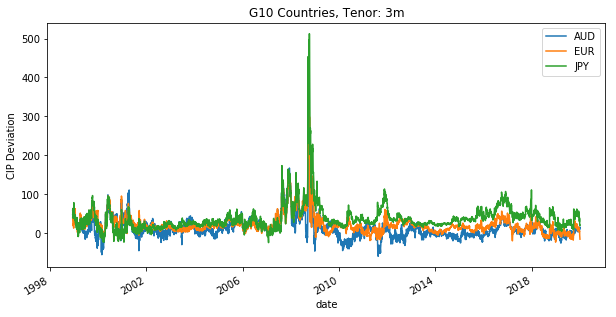

,CNY,INR
CNY,1.000000,0.341144
INR,0.341144,1.000000


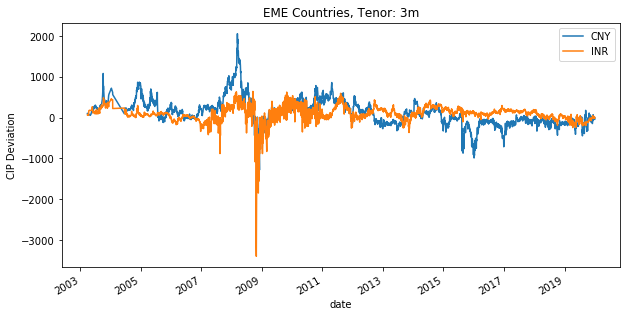

Tenor: 3y


,AUD,EUR,JPY
AUD,1.000000,0.540245,0.026686
EUR,0.540245,1.000000,0.485536
JPY,0.026686,0.485536,1.000000


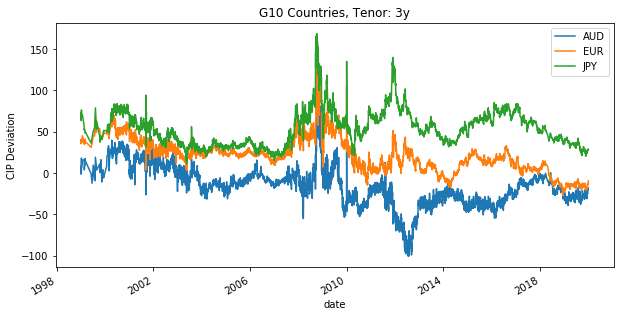

,CNY,INR
CNY,1.000000,0.638248
INR,0.638248,1.000000


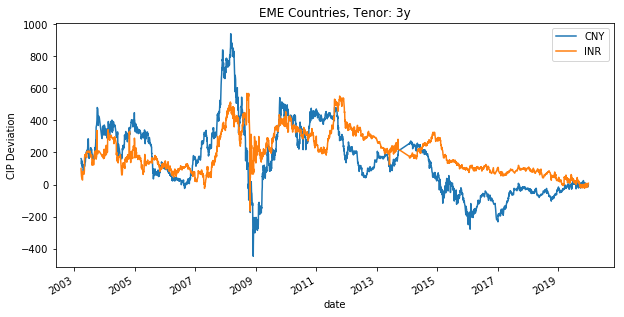

In [62]:
for tenor in tenors:
    print("Tenor: " + str(tenor))
    df = data[data['tenor'] == tenor]
    df = df[df['currency'].isin(g10)][['currency', 'cip_govt']]
        
    g10_data = pd.DataFrame()
    AUD = pd.DataFrame(df[df['currency'] == 'AUD']['cip_govt'].values, columns=['AUD'], index=df[df['currency'] == 'AUD']['cip_govt'].index)
    EUR = pd.DataFrame(df[df['currency'] == 'EUR']['cip_govt'].values, columns=['EUR'], index=df[df['currency'] == 'EUR']['cip_govt'].index)
    JPY = pd.DataFrame(df[df['currency'] == 'JPY']['cip_govt'].values, columns=['JPY'], index=df[df['currency'] == 'JPY']['cip_govt'].index)
    g10_data = AUD.merge(EUR, left_index=True, right_index=True)
    g10_data = g10_data.merge(JPY, left_index=True, right_index=True)
    display(g10_data.corr())
    
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set(xlabel="Date",ylabel="CIP Deviation",title="G10 Countries, Tenor: " + str(tenor))
    g10_data.plot(legend=True, ax=ax)
    plt.show()
    
    
    df = data[data['tenor'] == tenor]
    df = df[df['currency'].isin(eme)][['currency', 'cip_govt']]
        
    eme_data = pd.DataFrame()
    CNY = pd.DataFrame(df[df['currency'] == 'CNY']['cip_govt'].values, columns=['CNY'], index=df[df['currency'] == 'CNY']['cip_govt'].index)
    INR = pd.DataFrame(df[df['currency'] == 'INR']['cip_govt'].values, columns=['INR'], index=df[df['currency'] == 'INR']['cip_govt'].index)
    eme_data = CNY.merge(INR, left_index=True, right_index=True)
    display(eme_data.corr())
    
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set(xlabel="Date",ylabel="CIP Deviation",title="EME Countries, Tenor: " + str(tenor))
    eme_data.plot(legend=True, ax=ax)
    plt.show()

1. G10 more correlated for smaller tenor while less correlated for higher tenor
2. EME less correlated for larger tenor while more correlated for higher tenor

# PCA using all G10 and all EME

In [97]:
data = pd.read_csv('cip_dataset_v2.csv').dropna()

data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

data.head()

,group,currency,tenor,rho,cip_govt,diff_y
date,,,,,,
1997-03-27,g10,AUD,10y,1.055,-2.5,1.03
1997-03-28,g10,AUD,10y,1.055,-13.5,0.92
1997-03-31,g10,AUD,10y,1.045,-0.5,1.04
1997-04-01,g10,AUD,10y,1.195,-3.5,1.16
1997-04-02,g10,AUD,10y,1.210,1.0,1.22


array([0.68473572, 0.1081624 , 0.07509725, 0.06342423, 0.02794187,
       0.02509072, 0.01554781])

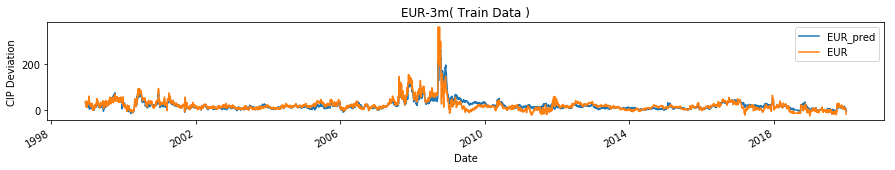

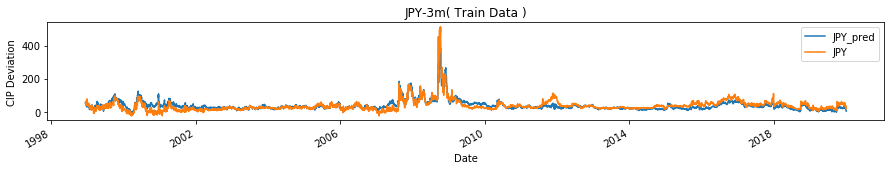

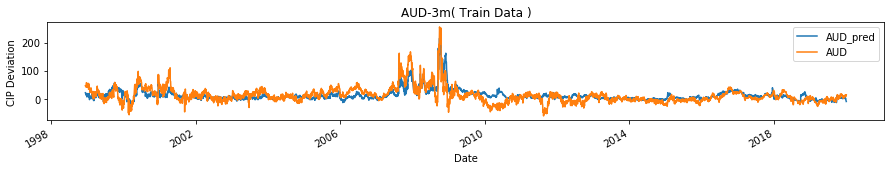

array([0.50498404, 0.22237592, 0.1372445 , 0.06290375, 0.03139004,
       0.02488394, 0.0162178 ])

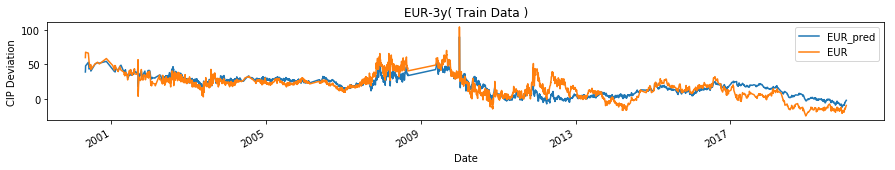

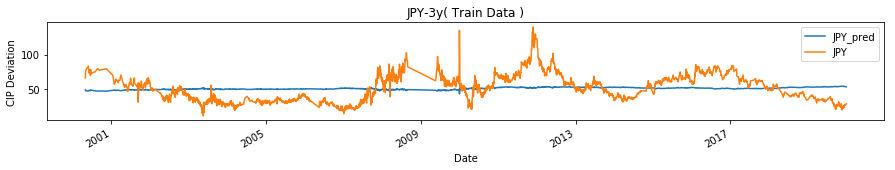

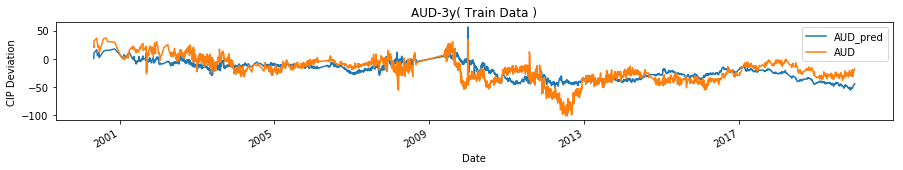

In [110]:
for tenor in tenors:
    df = data[data['tenor'] == tenor]
    g10_data = pd.DataFrame(df[df['currency'] == 'AUD']['cip_govt'].values, columns=['AUD'], index=df[df['currency'] == 'AUD']['cip_govt'].index)
    for currency in data[data['group'] == 'g10']['currency'].unique():
        if currency != 'AUD':
            dt = pd.DataFrame(df[df['currency'] == currency]['cip_govt'].values, columns=[currency], index=df[df['currency'] == currency]['cip_govt'].index)
            g10_data = g10_data.merge(dt, left_index=True, right_index=True)
    pca = PCA()
    g10_data_t = g10_data.loc[:, ~g10_data.columns.isin(g10)]
    pca.fit(g10_data_t)
    pca1 = pca.components_[0]
    X = np.dot(g10_data_t, pca1)
    display(pca.explained_variance_ratio_)
    for currency in g10:
        Y = g10_data[currency] 
        X = sm.add_constant(X)
        
        model = sm.OLS(Y,X)
        results = model.fit()
        
        g10_data[currency+"_pred"] = np.dot(X, results.params)
        g10_data[currency+"_resid"] = results.resid.values
        
        fig, ax = plt.subplots(figsize=(15, 2))
        g10_data[currency+"_pred"].plot(legend=True)
        g10_data[currency].plot(legend=True)
        ax.set(xlabel="Date",ylabel="CIP Deviation",title=currency + "-" + tenor + "( Train Data )")
        plt.show()

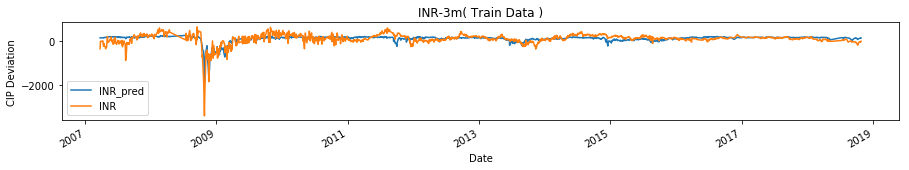

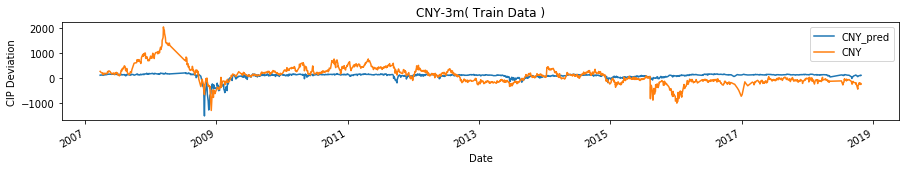

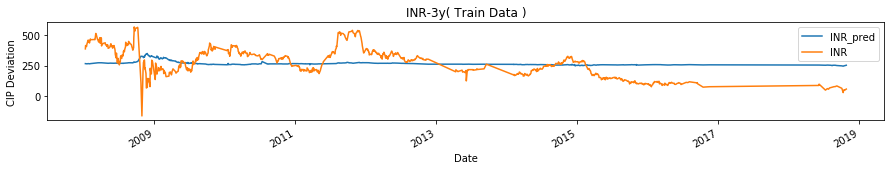

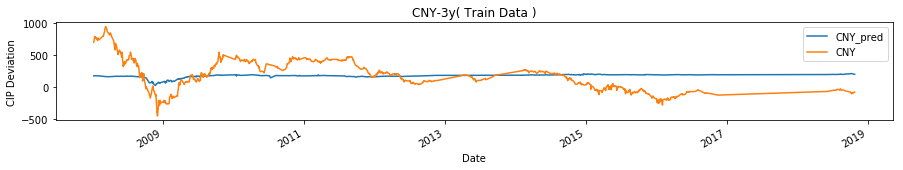

In [112]:
for tenor in tenors:
    df = data[data['tenor'] == tenor]
    eme_data = pd.DataFrame(df[df['currency'] == 'INR']['cip_govt'].values, columns=['INR'], index=df[df['currency'] == 'INR']['cip_govt'].index)
    for currency in data[data['group'] == 'eme']['currency'].unique():
        if currency != 'INR':
            dt = pd.DataFrame(df[df['currency'] == currency]['cip_govt'].values, columns=[currency], index=df[df['currency'] == currency]['cip_govt'].index)
            eme_data = eme_data.merge(dt, left_index=True, right_index=True)
    pca = PCA()
    eme_data_t = eme_data.loc[:, ~eme_data.columns.isin(eme)]
    pca.fit(eme_data_t)
    pca1 = pca.components_[0]
    X = np.dot(eme_data_t, pca1)
    for currency in eme:
        Y = eme_data[currency] 
        X = sm.add_constant(X)
        
        model = sm.OLS(Y,X)
        results = model.fit()
        
        eme_data[currency+"_pred"] = np.dot(X, results.params)
        eme_data[currency+"_resid"] = results.resid.values
        
        fig, ax = plt.subplots(figsize=(15, 2))
        eme_data[currency+"_pred"].plot(legend=True)
        eme_data[currency].plot(legend=True)
        ax.set(xlabel="Date",ylabel="CIP Deviation",title=currency + "-" + tenor + "( Train Data )")
        plt.show()